In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import pygam
import statsmodels.api as sm
import matplotlib.pyplot as plt
import uuid

from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, s, te
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pygam import GammaGAM
from datetime import datetime, timezone
from pathlib import Path

plt.style.use("ggplot")

# Estimate daily concentrations of River Water Chemistry Data

This notebook loads water chemistry and discharge datasets from NetCDF files, harmonizes and merges data by station and date, and constructs a continuous daily time series by interpolating missing values using multiple methods:
* **Linear interpolation with gap control:** Performs linear interpolation on observed data, with a configurable maximum gap length.
* **Generalized Additive Models (GAMs):** Fits smooth functions of discharge and day-of-year using splines to model seasonal trends and discharge–variable interactions.
* **Monthly regression models (log–log discharge–chemistry):**  Fits separate linear models in log-log space for each month using discharge to predict chemistry, with predictions back-transformed to original units.
* **Monthly median interpolation to daily resolution:** Calculates monthly medians and interpolates them to daily resolution using time-based interpolation, capturing smooth seasonal trends where daily data are missing.

### How to run the analysis?
1. Clone the the AquaINFRA GitHub repository  
2. Install the follwing packages: xarray, pandas, numpy, pygam, matplotlib, scikit-learn, statsmodels
3. Set up your inputs:
    - Paths to water chemistry and discharge files 
    - Name mappings between datasets
    - List of chemical variables to interpolate
4. Configure parameters:
    - Interpolation: `max_gap`, `interp_method`, `interp_order`
    - Columns: `date_col`, `station_col`, `discharge_col`
    - Best method selection: `candidate_suffixes`, `fallback_method`, `r2_threshold`, `z_score_limit`, `tolerance`, `extreme_ratio_limit` *(used for long gaps)*
5. Run the analysis

### Which programming languages are used?
- Python

### How does the workflow look like?
1. Define inputs
2. Load NetCDF files (water chemistry & discharge)
3. Rename and align stations by harmonized names
4. Join chemistry and discharge data into a continuous daily time series for each river
5. Estimate daily time series using multiple methods
6. Combine results from all estimation methods into a single dataframe
7. Evaluate methods using R2, RMSE, and MAE
8. Select the best method:
   - Evaluate candidate methods (annual gam, monthly regression, monthly interpolation):
     - Compute R2 for each method vs. observed data
     - Accept only methods with R2 ≥ threshold
   - Reject extreme predictions based on z-score + tolerance.
   - Select best method with the highest R2 that passes the above filters
   - If no method is valid, use as fallback method linear interpolation.
   - Fill remaining gaps:
     - Identify gaps in the selected method (gaps can appeared only for linear and monthly interpolation methods)
     - If the gap is longer than 4 years, check fallback candidates (annual_gam, monthly_regres)
     - Reject fallback candidates if their predicted values are too extreme (outside allowed ratio range)
     - Use fallback method to fill missing values
9. Visualize results
10. Store the selected/final interpolated time series as NetCDF

### Which functions are used and how are they connected?
- `load_netcdf_to_dataframes()` – Loads NetCDF files and converts them to pandas DataFrames, ensuring proper datetime parsing for time variables.
- `process_river_dfs()` – Standardizes the time and name columns, normalizes dates to daily resolution, and renames rivers for consistency.
- `merge_daily_river_data()` – Merges chemistry and discharge data into daily time series per station, handling duplicates and ensuring complete date coverage.
- `interpolate_with_gap_limit()` – Helper function used to fill missing values only if the gap is within a defined maximum size. Prevents interpolation over long missing stretches. Used inside `interpolate_station_df()`.
- `interpolate_station_df()` – Applies linear interpolation with a maximum gap limit to chemistry variables.
- `compute_gam()` – Fits a Generalized Additive Model (GAM) to estimate chemistry based on discharge and day-of-year (DOY), producing daily water chemistry data.
- `apply_gam_to_all_rivers()` – Applies compute_gam() function across all stations and all selected chemistry variables.
- `monthly_medians_to_daily_interpolation_all_years()` – Computes monthly medians of each variable, then converts them into daily values over multiple years.
- `interpolate_monthly_to_daily()` – Helper function for daily interpolation of monthly values for a given year.
- `plot_qc_interpolation()` – Visualizes raw data versus interpolated values per variable and station.

In [2]:
def load_netcdf_to_dataframes(filepaths, time_vars=("sample_date", "time")):
    """
    Loads a list of NetCDF files into pandas DataFrames.

    Parameters:
        filepaths: Paths to NetCDF files.
        time_vars: Column names to convert to datetime.

    Returns:
        list of tuples: Each tuple contains the filename and its corresponding DataFrame.
    """
    
    dataframes = []

    for fp in filepaths:
        ds = xr.open_dataset(fp)
        df = ds.to_dataframe().reset_index()

        for time_var in time_vars:
            if time_var in df.columns:
                df[time_var] = pd.to_datetime(df[time_var], errors="coerce")

        dataframes.append((Path(fp).name, df))
    
    return dataframes

def process_river_dfs(dfs, time_col_name, station_rename_map, date_col="date", station_col="station_name", standard_station_col="river_name"):
    """
    Processes a list of DataFrames by:
    - Renaming the time column to a consistent name
    - Converting the date column to datetime
    - Normalizing timestamps to keep only the date part
    - Renaming station names using the provided mapping
    - Renaming the station column to a standard name (e.g. 'river_name')

    Parameters:
        dfs: List of (filename, DataFrame) from NetCDF files.
        time_col_name: Name of the time column to convert and rename.
        station_rename_map: Dict to standardize station names.
        date_col: New name for the time column (default: "date").
        station_col: Name of the original station column (default: "station_name").
        standard_station_col: Final name for the renamed station column (default: "river_name").

    Returns:
        List of tuples: (filename, processed DataFrame)
    """
    processed_dfs = []

    for fname, df in dfs:

        if time_col_name in df.columns:
            df = df.rename(columns={time_col_name: date_col})
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df[date_col] = df[date_col].dt.normalize()

        if station_col in df.columns:
            df[station_col] = df[station_col].replace(station_rename_map)
            df = df.rename(columns={station_col: standard_station_col})

        processed_dfs.append((fname, df))

    return processed_dfs


def merge_daily_river_data(wc_dfs, q_dfs, station_col="river_name", date_col="date", discharge_col="discharge", drop_cols=False):
    """
    Merge water chemistry and discharge data per river into daily time series,
    handling duplicates by aggregating (mean over duplicate days).

    Parameters:
        wc_dfs: List of (filename, DataFrame) tuples for water chemistry.
        q_dfs: List of (filename, DataFrame) tuples for discharge.
        station_col: Column name used to match stations (default: 'river_name').
        date_col: Name of the date column to align on (default: 'date').
        discharge_col: Name of the discharge column (default: 'discharge').
        drop_cols: List of column names to drop from water chemistry data before merging.
                   Set to False to skip dropping any columns.
                   
    Returns:
        List of (station_name, merged DataFrame) tuples.
    """
    merged_river_dfs = []

    for wc_fname, wc_df in wc_dfs:
        station_name = wc_df[station_col].iloc[0]

        q_match = [q_df for _, q_df in q_dfs if q_df[station_col].iloc[0] == station_name]
        if not q_match:
            print(f"No discharge data for station '{station_name}'")
            continue
        q_df = q_match[0]

        q_df = q_df.drop_duplicates(subset=date_col)

        full_dates = pd.date_range(start=q_df[date_col].min(), end=q_df[date_col].max(), freq='D')
        full_df = pd.DataFrame({date_col: full_dates})

        merged = pd.merge(full_df, q_df[[date_col, discharge_col]], on=date_col, how='left')

        if isinstance(drop_cols, list):
            wc_df = wc_df.drop(columns=drop_cols, errors='ignore')

        merged = pd.merge(merged, wc_df, on=date_col, how='left')

        merged = merged.drop(columns=[station_col], errors='ignore')

        numeric_cols = merged.select_dtypes(include='number').columns.tolist()
        agg_df = (merged.groupby(date_col)[numeric_cols].mean().reset_index())

        agg_df[station_col] = station_name

        columns_order = [date_col, station_col, discharge_col] + [col for col in agg_df.columns if col not in [date_col, station_col, discharge_col]]
        agg_df = agg_df[columns_order]

        merged_river_dfs.append((station_name, agg_df))

    return merged_river_dfs


def interpolate_with_gap_limit(series, max_gap, method='linear', order=None):
    """
    Interpolate a pandas Series, limiting the maximum consecutive NaNs to fill.

    Parameters:
        series: The input data series with missing values.
        max_gap: Maximum number of consecutive NaNs to fill.
        method: Interpolation method (e.g., 'linear', 'polynomial', 'spline').
        order: Order of interpolation (required for 'spline' and 'polynomial').

    Returns:
        pd.Series: Interpolated series, with long gaps left unfilled.
    """
    if method in ['spline', 'polynomial'] and order is None:
        raise ValueError(f"Interpolation method '{method}' requires an 'order' argument.")
    
    return series.interpolate(method=method, limit=max_gap, order=order)

    
def interpolate_station_df(df, variables, max_gap=30, method='linear', order=None, meta_cols=None, date_col='date'):
    """
    Applies gap-limited interpolation to a list of variables in a station DataFrame.

    Parameters:
        df: Input DataFrame.
        variables: List of column names to interpolate.
        max_gap: Maximum consecutive NaNs to interpolate (in days).
        method: Interpolation method ('linear', 'spline', 'polynomial', etc.).
        order: Required if using spline/polynomial interpolation.
        meta_cols: List of metadata columns (e.g., station name/id) to forward/backward fill. These columns are preserved across all daily dates.
        date_col: Name of the datetime column (default: 'date').

    Returns:
        pd.DataFrame: Interpolated DataFrame with new *_linear_interp columns.
    """
    df = df.copy()
    
    if not meta_cols:
        raise ValueError("You must specify meta_cols for forward/backward fill.")

    df[date_col] = pd.to_datetime(df[date_col])
    df = df.drop_duplicates(subset=date_col)
    df = df.set_index(date_col).resample("D").asfreq()

    for col in meta_cols:
        if col in df.columns:
            df[col] = df[col].ffill().bfill()

    for var in variables:
        if var in df.columns:
            df[f"{var}_linear_interp"] = interpolate_with_gap_limit(df[var], max_gap=max_gap, method=method, order=order)

    return df.reset_index()

    
def compute_gam(df, var, discharge_col='discharge', date_col='date', station_name=None):
    """
    Fits a Generalized Additive Model (GAM) to estimate the daily values of a water chemistry variable
    based on discharge and seasonal patterns (day-of-year).

    Parameters:
        df: Input DataFrame for a single station.
        var: Name of the variable to model (e.g., 'TOTP').
        discharge_col: Column name for discharge values (default: 'discharge').
        date_col (str): Name of the datetime column (default: 'date').
        station_name (str, optional): Station name (used in print/log messages).

    Returns:
        pd.DataFrame: Copy of the original DataFrame with a new column '<var>_annual_gam' containing predicted values where valid inputs exist.
                      Returns None if training data is insufficient or model fitting fails.
    """

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df['doy'] = df[date_col].dt.dayofyear

    train_df = df.dropna(subset=[var, discharge_col, 'doy']).copy()
    if train_df.empty:
        print(f"No training data for {station_name} -> {var}")
        return None

    X_train = train_df[[discharge_col, 'doy']].values
    y_train = train_df[var].values

    model = LinearGAM(te(0, 1, n_splines=[10, 20], spline_order=[3, 3]) + s(1, basis='cp'))
    lam_grid = np.logspace(-3, 3, 7)

    try:
        gam_model = model.gridsearch(X_train, y_train, lam=lam_grid)
    except Exception as e:
        print(f"GAM fitting failed for {station_name} → {var}: {e}")
        return None

    first_valid_date = train_df[date_col].min()
    last_valid_date = train_df[date_col].max()
    
    mask = (df[discharge_col].notna() & df['doy'].notna() & (df[date_col] >= first_valid_date) & (df[date_col] <= last_valid_date))
    
    X_pred = df.loc[mask, [discharge_col, 'doy']].values
    y_pred = gam_model.predict(X_pred)
    y_pred[y_pred < 0] = 0  # remove negatives
    
    df[f'{var}_annual_gam'] = np.nan
    df.loc[mask, f'{var}_annual_gam'] = y_pred

    y_pred_train = gam_model.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred_train)
    mse = mean_squared_error(y_train, y_pred_train)
    r2 = r2_score(y_train, y_pred_train)
    print(f"GAM for {station_name} -> {var}: MAE={mae:.2f}, MSE={mse:.2f}, R²={r2:.3f}")

    return df


def apply_gam_to_all_rivers(merged_river_dfs, variables, discharge_col='discharge', date_col='date'):
    """
    Applies GAM-based interpolation to a list of chemistry variables for each river station.

    Parameters:
        merged_river_dfs: List of (station_name, DataFrame) tuples, typically returned by merge_daily_river_data().
        variables: List of variable names to model (e.g., ['TOTP', 'DOC']).
        discharge_col: Name of the discharge column used as a predictor (default: 'discharge').
        date_col: Name of the datetime column (default: 'date').

    Returns:
        list of tuples: Each element is (station_name, DataFrame) with additional '<variable>_annual_gam' columns for each modeled variable.
                        If GAM fitting fails for a variable, the original DataFrame is preserved.
    """
    results = []

    for station_name, df in merged_river_dfs:
        df_out = df.copy()
        for var in variables:
            if var in df_out.columns:
                gam_df = compute_gam(df_out, var, discharge_col=discharge_col, date_col=date_col, station_name=station_name)
                if gam_df is not None:
                    df_out = gam_df  # overwrite with interpolated column
        results.append((station_name, df_out))

    return results

def interpolate_monthly_to_daily(df, year):
    """
    Converts a monthly median time series to daily resolution for a single year.

    This function assumes that the input DataFrame `df` has months (1–12) as the index 
    and one or more columns representing variables. It shifts the monthly values to 
    approximate mid-month dates, interpolates to daily values using a time-based method, 
    and fills the start and end of the year based on January 15 and December 15 values.

    Parameters:
        df: DataFrame indexed by month (integers 1–12), with variable columns.
        year: The year for which the daily interpolation is to be constructed.

    Returns:
        pd.DataFrame: Daily-resolution DataFrame for the specified year with interpolated values.
                      Negative values are clipped to zero.
    """
    tmp_df = df.copy()
    tmp_df.index = pd.to_datetime(tmp_df.index.astype(str) + "-" + str(year), format="%m-%Y")
    tmp_df.index = tmp_df.index + pd.offsets.MonthBegin(1) - pd.Timedelta("17D")
    
    new_index = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31")
    tmp_df = tmp_df.reindex(new_index)

    df_daily_year = tmp_df.resample("D").asfreq()
    
    try:
        jan15 = df_daily_year.loc[f"{year}-01-15", :]
        dec15 = df_daily_year.loc[f"{year}-12-15", :]
        end_of_yr_val = (jan15 - dec15) / 2 + dec15
        df_daily_year.loc[f"{year}-01-01", :] = end_of_yr_val
        df_daily_year.loc[f"{year}-12-31", :] = end_of_yr_val
    except KeyError:
        pass

    df_daily_year = df_daily_year.interpolate(method="time")
    df_daily_year = df_daily_year.applymap(lambda x: 0 if x < 0 else x)
    
    return df_daily_year


def monthly_medians_to_daily_interpolation_all_years(station_df, variables):
    """
    Converts monthly medians of selected variables into daily interpolated values for all years.
    
    For each year in the station DataFrame, this function:
    - Computes the monthly median for each variable,
    - Interpolates the monthly values to daily resolution using `interpolate_monthly_to_daily()`,
    - Concatenates all years into a single daily DataFrame.
    
    Parameters:
        station_df: DataFrame with at least a 'date' column and the variables to interpolate.
        variables (list of str): List of variable names to process.
    
    Returns:
        daily_interp_all: Daily DataFrame with interpolated columns named as `{variable}_monthly_interp`.
    """
    daily_list = []

    station_df = station_df.copy()
    station_df['date'] = pd.to_datetime(station_df['date'])
    station_df = station_df.set_index('date')

    for year in sorted(station_df.index.year.unique()):
        year_df = station_df[station_df.index.year == year]

        monthly = year_df[variables].resample('M').median()
        monthly.index = monthly.index.month  # just month as index

        daily_interp_year = interpolate_monthly_to_daily(monthly, year=year)
        daily_list.append(daily_interp_year)

    daily_interp_all = pd.concat(daily_list)
    daily_interp_all = daily_interp_all.rename(columns=lambda col: f"{col}_monthly_interp")
    
    return daily_interp_all

    
def plot_qc_interpolation(df, var, station, method_colname, method_used, pars_metadata_df, param_col="parameter_name", unit_col="unit", station_col="river_name", date_col="date", r2_value=None):
    """
    Visualizes quality control of interpolated data by plotting raw and predicted values 
    for a given variable and station.

    Parameters:
        df: DataFrame containing raw and interpolated values.
        var: Name of the raw variable to plot.
        station: Station identifier to subset the data.
        method_colname: Name of the column with interpolated values.
        method_used: Label for the interpolation method used (shown in legend and title).
        pars_metadata_df: DataFrame containing variable metadata.
        param_col: Column in pars_metadata_df that contains variable names (default 'parameter_name').
        unit_col: Column in pars_metadata_df that contains units (default 'unit').
        station_col: Column name in df for station/river ID (default 'river_name').
        date_col: Column name in df for dates (default 'date').
        r2_value (float, optional): R2 of the selected method (included in title if provided).
    Returns:
        None. Displays a matplotlib plot.
    """
    # Filter to station
    df_station = df[df[station_col] == station].copy()

    raw_y = df_station[var]
    pred_y = df_station[method_colname]

    # Get units from metadata
    unit = ""
    if var in pars_metadata_df[param_col].values:
        unit_val = pars_metadata_df.loc[pars_metadata_df[param_col] == var, unit_col].values[0]
        unit = f" ({unit_val})"

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.scatter(df_station[date_col], raw_y, label="Raw Observations", color='black', alpha=0.7, s=30)
    plt.plot(df_station[date_col], pred_y, label=f"Interpolated ({method_used})", color='salmon', lw=2)

    title = f"{var} at {station} – Method: {method_used}"
    if r2_value is not None:
        title += f" (R2={r2_value:.2f})"

    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel(f"{var}{unit}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 0. Inputs

In [3]:
# Define input files 
wc_cleaned_data_dir = Path("../../data/river/water_chemistry/cleaned")
wc_cleaned_data_fpaths = list(wc_cleaned_data_dir.glob("cleaned_riverchem_*.nc"))

q_cleaned_data_dir = Path("../../data/river/discharge/clean")
q_cleaned_data_fpaths = list(q_cleaned_data_dir.glob("Q_daily_mean_*.nc"))

# Define renaming maps
wc_station_rename_map = {
    "Drammenselva": "Drammenselva",
    "Numedalslågen v/E18": "Numedalslagen",
    "Glomma, Sarpsfossen": "Glomma"
}

q_station_rename_map = {
    "Mjondalen bru": "Drammenselva",
    "Solbergfoss": "Glomma",
    "Holmfoss": "Numedalslagen"
}

# Define unnecessary columns 
columns_to_drop = ['latitude', 'longitude', 'station_id', 'station_code', 'station_type']

# List of chemical variables to interpolate
chem_variables = [
    "DOC", "Color", "NH4-N", "NO3-N", "TRP", "POC", "SPM", "SiO2",
    "TOC", "TOTN", "TDP", "PP", "TOTP", "TSM", "UV_Abs_254nm",
    "UV_Abs_410nm", "TOC_calc", "DIN", "DON"
]

# Units dictionary
# xx

# Name of columns to harmonize in all data sets
date_col = "date"
station_col = "river_name"
discharge_col = "discharge"

# Parameters for linear interpolation 
max_gap = 90
interp_method = 'linear'
interp_order = None
non_numeric_cols = ["date", "river_name"]

# Select method
candidate_suffixes = ['annual_gam', 'monthly_regres', 'monthly_interp']
fallback_method = 'linear_interp'
r2_threshold = 0.80
z_score_limit = 3
tolerance = 50
extreme_ratio_limit = 2.0  # Only apply if large gaps (>4 years)

# Metadata for saving as netCDF
river_coords = {
    "Drammenselva": {"lat": 59.75257593, "lon": 10.00789751},
    "Numedalslagen": {"lat": 59.10128295, "lon": 10.07094871},
    "Glomma": {"lat": 59.27980207, "lon": 11.13411158}
}

# Parameters metadata
pars_metadata_df = pd.DataFrame({
    "parameter_name": ["DOC", "Color", "NH4-N", "NO3-N", "TRP", "POC", "POC_calc", "TOC_calc", "SPM", "SiO2", "TOC", "TOTN", "TOTP", "TDP", "DIN", 
                       "DON", "PP", "TSM", "UV_Abs_254nm", "UV_Abs_410nm"],
    "unit":  ["mg/l C", "mg Pt/l", "µg/l", "µg/l", "µg/l", "mg/l", "mg/l", "mg/l", "mg/l", "mg/l", "mg/l", "µg/l", "µg/l", "µg/l P", "µg/l", 
              "µg/l", "µg/l P", "mg/l", "Abs/cm", "Abs/cm"]
})

# Define metadata columns name 
meta_par_name_col = "parameter_name"
meta_unit_col = "unit"

# Define a mapping from parameter names to long names
standard_name_map = {
    "DOC": "Dissolved Organic Carbon",
    "Color": "Water Color",
    "NH4-N": "Ammonium-N",
    "NO3-N": "Nitrate-N",
    "TRP": "Total Reactive Phosphorus",
    "POC": "Particulate Organic Carbon",
    "TOC_calc": "Total Organic Carbon Calculated",
    "SPM": "Suspended Particulate Matter", 
    "SiO2": "Silicate", 
    "TOC": "Total Organic Carbon",
    "TOTN": "Total Nitrogen",
    "TOTP": "Total Phosphorus",
    "TDP": "Total Dissolved Phosphorus",
    "DIN": "Dissolved Inorganic Nitrogen",
    "DON": "Dissolved Organic Nitrogen",
    "PP": "Particulate Phosphorus",
    "TSM": "Total Suspended Matter",
    "UV_Abs_254nm": "Ultraviolet Absorbance 254nm",
    "UV_Abs_410nm": "Ultraviolet Absorbance 410nm",
}

# Comments for selected variables
var_comments = {
    "DOC": {
        "Drammenselva": "The daily DOC time series was estimated using monthly median interpolation; 14 missing values were filled using the fallback DOC annual GAM time series.",
        "Glomma": "The daily DOC time series was estimated using monthly median interpolation; 28 missing values were filled using the fallback DOC monthly regression time series.",
        "Numedalslagen": "The daily DOC time series was estimated using monthly median interpolation; 14 missing values were filled using the fallback DOC monthly regression time series."
    },
    "Color": {
        "Drammenselva": "The daily color time series was estimated using annual GAM interpolation.",
        "Glomma": "The daily color time series was estimated using annual GAM interpolation.",
        "Numedalslagen": "The daily color time series was estimated using monthly median interpolation; 14 missing values were filled using the fallback color monthly regression time series."
    },
    "NH4-N": {
        "Drammenselva": "The daily NH4-N time series was estimated using monthly median interpolation; 87 missing values were filled using the fallback NH4-N annual GAM time series.",
        "Glomma": "The daily NH4-N time series was estimated using monthly median interpolation; 120 missing values were filled using the fallback NH4-N annual GAM time series.",
        "Numedalslagen": "The daily NH4-N time series was estimated using monthly median interpolation; 113 missing values were filled using the fallback NH4-N annual GAM time series."
    },
    "NO3-N": {
        "Drammenselva": "The daily NO3-N time series was estimated using linear interpolation; 53 missing values were filled using the fallback NO3-N annual GAM time series.",
        "Glomma": "The daily NO3-N time series was estimated using linear interpolation; 61 missing values were filled using the fallback NO3-N annual GAM time series.",
        "Numedalslagen": "The daily NO3-N time series was estimated using linear interpolation; 58 missing values were filled using the fallback NO3-N annual GAM time series."
    },
    "TRP": {
        "Drammenselva": "The daily TRP time series was estimated using linear interpolation.",
        "Glomma": "The daily TRP time series was estimated using monthly median interpolation; 112 missing values were filled using the fallback TRP annual GAM time series.",
        "Numedalslagen": "The daily TRP time series was estimated using monthly median interpolation; 70 missing values were filled using the fallback TRP annual GAM time series."
    },
    "POC": {
        "Drammenselva": "The daily POC time series was estimated using linear interpolation.",
        "Glomma": "The daily POC time series was estimated using linear interpolation.",
        "Numedalslagen": "The daily POC time series was estimated using monthly median interpolation; 25 missing values were filled using the fallback POC monthly regression time series."
    },
    "SPM": {
        "Drammenselva": "The daily SPM time series was estimated using linear interpolation.",
        "Glomma": "The daily SPM time series was estimated using linear interpolation; 108 missing values were filled using the fallback SPM monthly regression time series.",
        "Numedalslagen": "The daily SPM time series was estimated using monthly median interpolation; 14 missing values were filled using the fallback SPM monthly regression time series."
    },
    "SiO2": {
        "Drammenselva": "The daily SiO2 time series was estimated using linear interpolation.",
        "Glomma": "The daily SiO2 time series was estimated using monthly median interpolation; 155 missing values were filled using the fallback SiO2 annual GAM time series.",
        "Numedalslagen": "The daily SiO2 time series was estimated using monthly median interpolation; 70 missing values were filled using the fallback SiO2 monthly regression time series."
    },
    "TOC": {
        "Drammenselva": "The daily TOC time series was estimated using monthly median interpolation; 948 missing values were filled using the fallback TOC annual GAM time series.",
        "Glomma": "The daily TOC time series was estimated using monthly median interpolation; 1220 missing values were filled using the fallback TOC annual GAM time series.",
        "Numedalslagen": "The daily TOC time series was estimated using monthly median interpolation; 70 missing values were filled using the fallback TOC annual GAM time series."
    },
    "TOTN": {
        "Drammenselva": "The daily TOTN time series was estimated using linear interpolation.",
        "Glomma": "The daily TOTN time series was estimated using linear interpolation.",
        "Numedalslagen": "The daily TOTN time series was estimated using monthly median interpolation; 84 missing values were filled using the fallback TOTN annual GAM time series."
    },
    "TDP": {
        "Drammenselva": "The daily TDP time series was estimated using linear interpolation.",
        "Glomma": "The daily TDP time series was estimated using monthly median interpolation; 14 missing values were filled using the fallback TDP monthly regression time series.",
        "Numedalslagen": "The daily TDP time series was estimated using monthly median interpolation; 28 missing values were filled using the fallback TDP monthly regression time series."
    },
     "PP": {
        "Drammenselva": "The daily PP time series was estimated using linear interpolation.",
        "Glomma": "The daily PP time series was estimated using linear interpolation.",
        "Numedalslagen": "The daily PP time series was estimated using annual GAM interpolation."
    },
    "TOTP": {
        "Drammenselva": "The daily TOTP time series was estimated using linear interpolation; 1758 missing values were filled using the fallback TOTP monthly regression time series.",
        "Glomma": "The daily TOTP time series was estimated using linear interpolation; 1762 missing values were filled using the fallback TOTP monthly regression time series.",
        "Numedalslagen": "The daily TOTP time series was estimated using monthly median interpolation; 1840 missing values were filled using the fallback TOTP monthly regression time series."
    },
    "TSM": {
        "Drammenselva": "The daily TSM time series was estimated using linear interpolation.",
        "Glomma": "The daily TSM time series was estimated using linear interpolation.",
        "Numedalslagen": "The daily TSM time series was estimated using monthly median interpolation; 70 missing values were filled using the fallback TSM annual GAM time series."
    },
     "UV_Abs_254nm": {
        "Drammenselva": "The daily UV_Abs_254nm time series was estimated using annual GAM interpolation.",
        "Glomma": "The daily UV_Abs_254nm time series was estimated using monthly median interpolation; 28 missing values were filled using the fallback UV_Abs_254nm monthly regression time series.",
        "Numedalslagen": "The daily UV_Abs_254nm time series was estimated using linear interpolation."
    },
    "UV_Abs_410nm": {
        "Drammenselva": "The daily UV_Abs_410nm time series was estimated using annual GAM interpolation.",
        "Glomma": "The daily UV_Abs_410nm time series was estimated using monthly median interpolation; 28 missing values were filled using the fallback UV_Abs_410nm monthly regression time series.",
        "Numedalslagen": "The daily UV_Abs_410nm time series was estimated using linear interpolation."
    },
    "TOC_calc": {
        "Drammenselva": "The daily TOC_calc time series was estimated using annual GAM interpolation.",
        "Glomma": "The daily TOC_calc time series was estimated using monthly median interpolation; 37 missing values were filled using the fallback TOC_calc monthly regression time series.",
        "Numedalslagen": "The daily TOC_calc time series was estimated using monthly linear interpolation; 25 missing values were filled using the fallback TOC_calc monthly regression time series."
    },
    "DIN": {
        "Drammenselva": "The daily DIN time series was estimated using linear interpolation; 53 missing values were filled using the fallback DIN annual GAM time series.",
        "Glomma": "The daily DIN time series was estimated using linear interpolation; 61 missing values were filled using the fallback DIN monthly regression time series.",
        "Numedalslagen": "The daily DIN time series was estimated using monthly linear interpolation; 58 missing values were filled using the fallback DIN annual GAM time series."
    },
    "DON": {
        "Drammenselva": "The daily DON time series was estimated using linear interpolation; 53 missing values were filled using the fallback DON annual GAM time series.",
        "Glomma": "The daily DIN time series was estimated using linear interpolation; 61 missing values were filled using the fallback DON monthly regression time series.",
        "Numedalslagen": "The daily DON time series was estimated using monthly linear interpolation; 84 missing values were filled using the fallback DON annual GAM time series."
    }    
}

global_metadata_config = {
    "naming_authority": "no.niva",
    "project": "AquaINFRA",
    "iso_topic_category": "inlandWaters",
    "featureType": "timeSeries",
    "spatial_representation": "point",
    "creator_type": "institution",
    "creator_institution": "Norwegian Institute for Water Research (NIVA)",
    "institution": "Norwegian Institute for Water Research (NIVA)",
    "institution_short_name": "NIVA",
    "creator_name": "Areti Balkoni",
    "creator_email": "areti.balkoni@niva.no",
    "creator_url": "https://www.niva.no/en/employees/areti-balkoni",
    "data_owner": "Norwegian Institute for Water Research",
    "processing_level": "Harmonized, gap-filled, and interpolated daily time series",
    "Conventions": "CF-1.7, ACDD-1.3",
    "publisher_name": "Norwegian Institute for Water Research",
    "publisher_email": "miljoinformatikk@niva.no",
    "publisher_institution": "Norwegian Institute for Water Research",
    "publisher_url": "https://niva.no",
    "license": "http://spdx.org/licenses/CC-BY-4.0(CC-BY-4.0)",
    "keywords": "GCMDSK:EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > WATER QUALITY/ WATER CHEMISTRY, GCMDLOC:CONTINENT > EUROPE > NORWAY",
    "keywords_vocabulary": "GCMDSK:GCMD Science Keywords, GCMDLOC:GCMD Locations",
    "history": (
        "Water chemistry and discharge data harmonized." 
        "Daily time series estimated using multiple interpolation methods: linear, GAM (Generalized Additive Models), "
        "monthly medians, and regression models. Fallback methods applied for missing values."
    )
}

processed_namespace_uuid = uuid.UUID("a23b7946-1a42-4d4a-bb0d-cf5a6cfb5670") 

# Where to save
# Plots
plots_output_dir_a = "../../figures/daily_wc_all_methods"
os.makedirs(plots_output_dir_a, exist_ok=True)

plots_output_dir_b = "../../figures/daily_wc_selected_methods"
os.makedirs(plots_output_dir_b, exist_ok=True)

# Data
output_dir = "../../data/river/water_chemistry/daily_estimations"
os.makedirs(output_dir, exist_ok=True)

### 1. Load data

In [4]:
wc_dfs = load_netcdf_to_dataframes(wc_cleaned_data_fpaths, time_vars=("sample_date", "time"))
q_dfs = load_netcdf_to_dataframes(q_cleaned_data_fpaths, time_vars=("date", "time"))

### 2. Data preparation

In [5]:
# Process both types of data
wc_dfs = process_river_dfs(wc_dfs, time_col_name="sample_date", station_rename_map=wc_station_rename_map, date_col=date_col, station_col="station_name", standard_station_col=station_col)
q_dfs = process_river_dfs(q_dfs, time_col_name="time", station_rename_map=q_station_rename_map, date_col=date_col, station_col="station_name", standard_station_col=station_col)

# Merge data for easier processing
merged_rivers = merge_daily_river_data(wc_dfs, q_dfs, station_col, date_col, discharge_col, drop_cols=columns_to_drop)
merged_rivers

[('Drammenselva',
              date    river_name  discharge  DOC  Color  NH4-N  NO3-N  TRP  POC  \
  0     1990-01-01  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
  1     1990-01-02  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
  2     1990-01-03  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
  3     1990-01-04  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
  4     1990-01-05  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
  ...          ...           ...        ...  ...    ...    ...    ...  ...  ...   
  12653 2024-08-23  Drammenselva    508.867  NaN    NaN    NaN    NaN  NaN  NaN   
  12654 2024-08-24  Drammenselva    591.747  NaN    NaN    NaN    NaN  NaN  NaN   
  12655 2024-08-25  Drammenselva    669.755  NaN    NaN    NaN    NaN  NaN  NaN   
  12656 2024-08-26  Drammenselva    733.868  NaN    NaN    NaN    NaN  NaN  NaN   
  12657 2024-08-27  Drammenselva    688.792  NaN    NaN    NaN    NaN

### 3. Estimate daily concentrations

#### 3.1 Linear interpolation 

In [6]:
# Apply interpolation to each merged river dataframe
interpolated_rivers = []

for station_name, df in merged_rivers:
    df_interp = interpolate_station_df(df, variables=chem_variables, max_gap=max_gap, method=interp_method, order=interp_order, date_col= date_col, meta_cols=non_numeric_cols)
    interpolated_rivers.append((station_name, df_interp))

df_linear_interp = pd.concat([df for _, df in interpolated_rivers], ignore_index=True)
df_linear_interp.head()

date    river_name  discharge  DOC  Color  NH4-N  NO3-N  TRP  POC  \
0 1990-01-01  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
1 1990-01-02  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
2 1990-01-03  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
3 1990-01-04  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
4 1990-01-05  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   

   SPM  ...  TOTN_linear_interp  TDP_linear_interp  PP_linear_interp  \
0  NaN  ...                 NaN                NaN               NaN   
1  NaN  ...                 NaN                NaN               NaN   
2  NaN  ...                 NaN                NaN               NaN   
3  NaN  ...                 NaN                NaN               NaN   
4  NaN  ...                 NaN                NaN               NaN   

   TOTP_linear_interp  TSM_linear_interp  UV_Abs_254nm_linear_interp  \
0                 NaN                NaN                         NaN   
1                 NaN                NaN                         NaN   
2                 NaN                NaN                         NaN   
3                 NaN                NaN                         NaN   
4                 NaN                NaN                         NaN   

   UV_Abs_410nm_linear_interp  TOC_calc_linear_interp  DIN_linear_interp  \
0                         NaN                     NaN                NaN   
1                         NaN                     NaN                NaN   
2                         NaN                     NaN                NaN   
3                         NaN                     NaN                NaN   
4                         NaN                     NaN                NaN   

   DON_linear_interp  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 41 columns]

#### 3.2 GAMs

In [7]:
gam_results = apply_gam_to_all_rivers(merged_river_dfs=merged_rivers, variables=chem_variables, discharge_col=discharge_col, date_col=date_col)
df_annual_gams = pd.concat([df for _, df in gam_results], ignore_index=True)
df_annual_gams.head()


  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> DOC: MAE=0.22, MSE=0.09, R²=0.809



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> Color: MAE=1.89, MSE=6.60, R²=0.850



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> NH4-N: MAE=6.43, MSE=69.84, R²=0.154



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> NO3-N: MAE=48.57, MSE=4887.00, R²=0.424



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> TRP: MAE=1.15, MSE=4.02, R²=0.509



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> POC: MAE=0.09, MSE=0.02, R²=0.003



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> SPM: MAE=2.93, MSE=24.22, R²=-0.004



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> SiO2: MAE=0.24, MSE=0.11, R²=0.556



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> TOC: MAE=0.29, MSE=0.15, R²=0.625



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> TOTN: MAE=60.74, MSE=7577.14, R²=0.315



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> TDP: MAE=0.85, MSE=1.66, R²=-0.023



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> PP: MAE=1.83, MSE=8.09, R²=-0.006



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> TOTP: MAE=1.81, MSE=8.89, R²=0.510



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Drammenselva -> TSM: MAE=1.16, MSE=4.37, R²=0.402



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> UV_Abs_254nm: MAE=0.01, MSE=0.00, R²=0.866



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> UV_Abs_410nm: MAE=0.00, MSE=0.00, R²=0.869



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> TOC_calc: MAE=0.24, MSE=0.10, R²=0.824



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> DIN: MAE=49.85, MSE=5118.30, R²=0.405



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Drammenselva -> DON: MAE=30.11, MSE=1584.83, R²=0.138



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Numedalslagen -> DOC: MAE=0.88, MSE=1.19, R²=0.520



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> Color: MAE=12.42, MSE=213.77, R²=-0.028



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Numedalslagen -> NH4-N: MAE=9.72, MSE=202.83, R²=0.452



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Numedalslagen -> NO3-N: MAE=74.44, MSE=10983.73, R²=0.380



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Numedalslagen -> TRP: MAE=2.80, MSE=21.08, R²=0.394



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> POC: MAE=0.22, MSE=0.12, R²=-0.000



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> SPM: MAE=3.49, MSE=22.15, R²=-0.003



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Numedalslagen -> SiO2: MAE=0.50, MSE=0.41, R²=0.538



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> TOC: MAE=0.78, MSE=0.95, R²=0.576



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> TOTN: MAE=99.06, MSE=17931.72, R²=0.368



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> TDP: MAE=1.40, MSE=3.93, R²=0.343



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> PP: MAE=2.10, MSE=9.77, R²=0.859



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> TOTP: MAE=4.58, MSE=54.39, R²=0.332



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:06

GAM for Numedalslagen -> TSM: MAE=2.65, MSE=18.63, R²=0.463



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:05

GAM for Numedalslagen -> UV_Abs_254nm: MAE=0.04, MSE=0.00, R²=0.535



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:01

GAM for Numedalslagen -> UV_Abs_410nm: MAE=0.00, MSE=0.00, R²=0.521



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Numedalslagen -> TOC_calc: MAE=0.96, MSE=1.40, R²=0.484



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Numedalslagen -> DIN: MAE=76.46, MSE=11669.71, R²=0.423



 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:010

GAM for Numedalslagen -> DON: MAE=36.84, MSE=2367.17, R²=0.354



 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:010

GAM for Glomma -> DOC: MAE=0.56, MSE=0.53, R²=0.516



 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:000

GAM for Glomma -> Color: MAE=2.71, MSE=10.35, R²=0.898



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> NH4-N: MAE=10.34, MSE=193.07, R²=0.316



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> NO3-N: MAE=72.27, MSE=9666.74, R²=0.465



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> TRP: MAE=3.98, MSE=36.27, R²=0.381



 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:000

GAM for Glomma -> POC: MAE=0.13, MSE=0.03, R²=-0.021



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> SPM: MAE=4.29, MSE=36.25, R²=-0.024



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> SiO2: MAE=0.46, MSE=0.40, R²=0.599



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> TOC: MAE=0.57, MSE=0.52, R²=0.573



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> TOTN: MAE=93.59, MSE=15934.46, R²=0.393



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> TDP: MAE=2.21, MSE=8.74, R²=0.168



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> PP: MAE=4.81, MSE=51.16, R²=-0.023



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> TOTP: MAE=7.29, MSE=130.38, R²=0.404



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> TSM: MAE=4.37, MSE=55.08, R²=0.401



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> UV_Abs_254nm: MAE=0.03, MSE=0.00, R²=0.559



 14% (1 of 7) |###                       | Elapsed Time: 0:00:00 ETA:   0:00:000

GAM for Glomma -> UV_Abs_410nm: MAE=0.00, MSE=0.00, R²=0.549



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> TOC_calc: MAE=0.63, MSE=0.67, R²=0.478



  0% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--:00

GAM for Glomma -> DIN: MAE=79.98, MSE=11540.48, R²=0.449



100% (7 of 7) |##########################| Elapsed Time: 0:00:02 Time:  0:00:020:00

GAM for Glomma -> DON: MAE=41.64, MSE=3091.14, R²=0.161


date    river_name  discharge  DOC  Color  NH4-N  NO3-N  TRP  POC  \
0 1990-01-01  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
1 1990-01-02  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
2 1990-01-03  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
3 1990-01-04  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
4 1990-01-05  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   

   SPM  ...  TOTN_annual_gam  TDP_annual_gam  PP_annual_gam  TOTP_annual_gam  \
0  NaN  ...              NaN             NaN            NaN              NaN   
1  NaN  ...              NaN             NaN            NaN              NaN   
2  NaN  ...              NaN             NaN            NaN              NaN   
3  NaN  ...              NaN             NaN            NaN              NaN   
4  NaN  ...              NaN             NaN            NaN              NaN   

   TSM_annual_gam  UV_Abs_254nm_annual_gam  UV_Abs_410nm_annual_gam  \
0             NaN                      NaN                      NaN   
1             NaN                      NaN                      NaN   
2             NaN                      NaN                      NaN   
3             NaN                      NaN                      NaN   
4             NaN                      NaN                      NaN   

   TOC_calc_annual_gam  DIN_annual_gam  DON_annual_gam  
0                  NaN             NaN             NaN  
1                  NaN             NaN             NaN  
2                  NaN             NaN             NaN  
3                  NaN             NaN             NaN  
4                  NaN             NaN             NaN  

[5 rows x 42 columns]

#### 3.3 Regressions
##### 3.3.1 Estimation of missing values based on monthly regressions

In [8]:
df_monthly_regres_interp = pd.DataFrame()

for station_name, station_df in merged_rivers:
    print(f"Processing station: {station_name}")
    
    station_df = station_df.copy()
    station_df = station_df.drop_duplicates(subset=[date_col, station_col])
    
    # Fill missing station info
    station_df[station_col] = station_df[station_col].ffill().bfill()
    
    # Add month/year columns
    station_df['month'] = pd.to_datetime(station_df[date_col]).dt.month
    station_df['year'] = pd.to_datetime(station_df[date_col]).dt.year

    for var in chem_variables:
        if var not in station_df.columns:
            continue

        first_date = station_df[var].first_valid_index()
        last_date = station_df[var].last_valid_index()
        if first_date is None or last_date is None:
            continue

        filtered_df = station_df.loc[first_date:last_date].copy()
        monthly_groups = filtered_df.groupby('month')

        for month, group in monthly_groups:
            y = group[var]
            X = group[[discharge_col]]

            train_df = group.dropna(subset=[var, discharge_col]).copy()

            # Log-transform: avoid log10(0) by replacing 0s with NaN temporarily
            train_df[f'log_{var}'] = np.log10(train_df[var].replace(0, np.nan)).fillna(0)
            train_df['log_discharge'] = np.log10(train_df[discharge_col].replace(0, np.nan)).fillna(0)

            X_train_log = train_df[['log_discharge']]
            y_train_log = train_df[f'log_{var}']

            if len(X_train_log) < 2:
                continue  # Not enough data to train

            model = LinearRegression()
            model.fit(X_train_log, y_train_log)

            # Apply to all values in the group
            X_all_log = np.log10(group[discharge_col].replace(0, np.nan)).fillna(0).values.reshape(-1, 1)
            predicted_log_y = model.predict(X_all_log)
            predicted_y = np.power(10, predicted_log_y)

            group[f'{var}_monthly_regres'] = predicted_y

            df_monthly_regres_interp = pd.concat([df_monthly_regres_interp, group], ignore_index=True)

            # Metrics on training data
            y_pred_train = model.predict(X_train_log)
            mae = mean_absolute_error(y_train_log, y_pred_train)
            mse = mean_squared_error(y_train_log, y_pred_train)
            r2 = r2_score(y_train_log, y_pred_train)
            # print(f"{station_name} -> {var} | MAE={mae:.3f}, MSE={mse:.3f}, R2={r2:.3f}")

Processing station: Drammenselva


C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: Use

Processing station: Numedalslagen


C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: Use

Processing station: Glomma


C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ARB\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: Use

##### 3.4 Monthly medians

In [9]:
final_dfs = []

for station_name, station_df in merged_rivers:
    print(f"Interpolating monthly data -> daily for {station_name}")

    daily_monthly_interp = monthly_medians_to_daily_interpolation_all_years(station_df, chem_variables)

    station_df = station_df.copy()
    station_df[date_col] = pd.to_datetime(station_df[date_col])
    station_df = station_df.set_index(date_col)

    merged_station = station_df.merge(daily_monthly_interp, left_index=True, right_index=True, how='left')
    merged_station.reset_index(inplace=True)

    final_dfs.append(merged_station)

df_monthly_interp = pd.concat(final_dfs, ignore_index=True)
df_monthly_interp

Interpolating monthly data -> daily for Drammenselva


C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = year_df[variables].resample('M').median()
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:297: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_daily_year = df_daily_year.applymap(lambda x: 0 if x < 0 else x)
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = year_df[variables].resample('M').median()
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:297: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_daily_year = df_daily_year.applymap(lambda x: 0 if x < 0 else x)
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in

Interpolating monthly data -> daily for Numedalslagen


C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = year_df[variables].resample('M').median()
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:297: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_daily_year = df_daily_year.applymap(lambda x: 0 if x < 0 else x)
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = year_df[variables].resample('M').median()
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:297: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_daily_year = df_daily_year.applymap(lambda x: 0 if x < 0 else x)
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in

Interpolating monthly data -> daily for Glomma


C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = year_df[variables].resample('M').median()
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:297: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_daily_year = df_daily_year.applymap(lambda x: 0 if x < 0 else x)
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = year_df[variables].resample('M').median()
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:297: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_daily_year = df_daily_year.applymap(lambda x: 0 if x < 0 else x)
C:\Users\ARB\AppData\Local\Temp\ipykernel_10140\2799490911.py:327: FutureWarning: 'M' is deprecated and will be removed in

date    river_name  discharge  DOC  Color  NH4-N  NO3-N  TRP  POC  \
0     1990-01-01  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
1     1990-01-02  Drammenselva    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
2     1990-01-03  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
3     1990-01-04  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
4     1990-01-05  Drammenselva    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
...          ...           ...        ...  ...    ...    ...    ...  ...  ...   
37969 2024-08-23        Glomma   1038.208  NaN    NaN    NaN    NaN  NaN  NaN   
37970 2024-08-24        Glomma   1214.979  NaN    NaN    NaN    NaN  NaN  NaN   
37971 2024-08-25        Glomma   1393.063  NaN    NaN    NaN    NaN  NaN  NaN   
37972 2024-08-26        Glomma   1604.250  NaN    NaN    NaN    NaN  NaN  NaN   
37973 2024-08-27        Glomma   1718.646  NaN    NaN    NaN    NaN  NaN  NaN   

       SPM  ...  TOTN_monthly_interp  TDP_monthly_interp  PP_monthly_interp  \
0      NaN  ...           348.500000                 NaN                NaN   
1      NaN  ...           348.607143                 NaN                NaN   
2      NaN  ...           348.714286                 NaN                NaN   
3      NaN  ...           348.821429                 NaN                NaN   
4      NaN  ...           348.928571                 NaN                NaN   
...    ...  ...                  ...                 ...                ...   
37969  NaN  ...           360.000000                 3.0                9.0   
37970  NaN  ...           360.000000                 3.0                9.0   
37971  NaN  ...           360.000000                 3.0                9.0   
37972  NaN  ...           360.000000                 3.0                9.0   
37973  NaN  ...           360.000000                 3.0                9.0   

       TOTP_monthly_interp  TSM_monthly_interp  UV_Abs_254nm_monthly_interp  \
0                 7.000000            0.850000                          NaN   
1                 6.928571            0.846429                          NaN   
2                 6.857143            0.842857                          NaN   
3                 6.785714            0.839286                          NaN   
4                 6.714286            0.835714                          NaN   
...                    ...                 ...                          ...   
37969            12.000000            5.730000                     0.184576   
37970            12.000000            5.730000                     0.184576   
37971            12.000000            5.730000                     0.184576   
37972            12.000000            5.730000                     0.184576   
37973            12.000000            5.730000                     0.184576   

       UV_Abs_410nm_monthly_interp  TOC_calc_monthly_interp  \
0                              NaN                      NaN   
1                              NaN                      NaN   
2                              NaN                      NaN   
3                              NaN                      NaN   
4                              NaN                      NaN   
...                            ...                      ...   
37969                     0.017648                     4.77   
37970                     0.017648                     4.77   
37971                     0.017648                     4.77   
37972                     0.017648                     4.77   
37973                     0.017648                     4.77   

       DIN_monthly_interp  DON_monthly_interp  
0                     NaN                 NaN  
1                     NaN                 NaN  
2                     NaN                 NaN  
3                     NaN                 NaN  
4                     NaN                 NaN  
...                   ...                 ...  
37969               202.0               158.0  


### 4. Compile interpolated outputs from all methods into a single DataFrame and visualize them for comparison

In [10]:
merged_df1 = pd.merge(df_linear_interp, df_annual_gams, on=[station_col, date_col, discharge_col], how='left', suffixes=('', '_drop'))
merged_df1 = merged_df1.loc[:, ~merged_df1.columns.str.endswith('_drop')]

merged_df2 = pd.merge(merged_df1, df_monthly_regres_interp, on=[station_col, date_col, discharge_col], how='left', suffixes=('', '_drop'))
cols_to_drop = [f"{col}_drop" for col in chem_variables if f"{col}_drop" in merged_df2.columns]
merged_df2 = merged_df2.drop(columns=cols_to_drop) # Drop any duplicated chemistry columns 

merged_df3 = pd.merge(merged_df2, df_monthly_interp, on=[station_col, date_col, discharge_col], how='left', suffixes=('', '_drop'))
cols_to_drop = [f"{col}_drop" for col in chem_variables if f"{col}_drop" in merged_df3.columns]
merged_df3 = merged_df3.drop(columns=cols_to_drop) # Drop duplicate chemistry columns from the right-hand side

# Group and aggregate daily values
df_grouped = merged_df3.groupby([date_col, station_col]).agg(lambda x: x.mean() if pd.api.types.is_numeric_dtype(x) else x.iloc[0]).reset_index()

# Resample to daily for each station
df_grouped.set_index(date_col, inplace=True)
df_daily_all = df_grouped.groupby(station_col).resample('D').mean(numeric_only=True).reset_index()

# Sort 
df_daily_all.sort_values(by=[station_col, date_col], inplace=True)
df_daily_all.head()

river_name       date  discharge  DOC  Color  NH4-N  NO3-N  TRP  POC  \
0  Drammenselva 1990-01-01    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
1  Drammenselva 1990-01-02    264.683  NaN    NaN    NaN    NaN  NaN  NaN   
2  Drammenselva 1990-01-03    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
3  Drammenselva 1990-01-04    260.215  NaN    NaN    NaN    NaN  NaN  NaN   
4  Drammenselva 1990-01-05    260.215  NaN    NaN    NaN    NaN  NaN  NaN   

   SPM  ...  TOTN_monthly_interp  TDP_monthly_interp  PP_monthly_interp  \
0  NaN  ...           348.500000                 NaN                NaN   
1  NaN  ...           348.607143                 NaN                NaN   
2  NaN  ...           348.714286                 NaN                NaN   
3  NaN  ...           348.821429                 NaN                NaN   
4  NaN  ...           348.928571                 NaN                NaN   

   TOTP_monthly_interp  TSM_monthly_interp  UV_Abs_254nm_monthly_interp  \
0             7.000000            0.850000                          NaN   
1             6.928571            0.846429                          NaN   
2             6.857143            0.842857                          NaN   
3             6.785714            0.839286                          NaN   
4             6.714286            0.835714                          NaN   

   UV_Abs_410nm_monthly_interp  TOC_calc_monthly_interp  DIN_monthly_interp  \
0                          NaN                      NaN                 NaN   
1                          NaN                      NaN                 NaN   
2                          NaN                      NaN                 NaN   
3                          NaN                      NaN                 NaN   
4                          NaN                      NaN                 NaN   

   DON_monthly_interp  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 101 columns]

In [11]:
if date_col not in df_daily_all.columns:
    df_daily_all = df_daily_all.reset_index()
df_daily_all[date_col] = pd.to_datetime(df_daily_all[date_col])

stations = df_daily_all[station_col].unique()

for var in chem_variables:
    fig, axes = plt.subplots(nrows=1, ncols=len(stations), figsize=(6 * len(stations), 6))
    if len(stations) == 1:
        axes = [axes]

    # Get unit from metadata
    unit = ""
    if var in pars_metadata_df[meta_par_name_col].values:
        unit_val = pars_metadata_df.loc[pars_metadata_df[meta_par_name_col] == var, meta_unit_col].values[0]
        unit = f" ({unit_val})"

    for ax, station in zip(axes, stations):
        df_station = df_daily_all[df_daily_all[station_col] == station]

        ax.scatter(df_station[date_col], df_station[var],
                   label='Raw Data', marker='o', facecolors='white', edgecolors='black',
                   s=30, alpha=0.8, zorder=4)

        # Plot interpolations
        for label, style, color in [
            (f"{var}_monthly_interp", '-', None),
            (f"{var}_linear_interp", '-', 'orange'),
            (f"{var}_annual_gam", '--', 'darkcyan'),
            (f"{var}_monthly_regres", '--', 'brown')
        ]:
            if label in df_station.columns:
                ax.plot(df_station[date_col], df_station[label],
                        label=label.replace(f"{var}_", '').replace('_', ' ').title(),
                        linestyle=style, color=color, alpha=0.7)

        ax.set_title(station)
        ax.set_xlabel(date_col)
        ax.set_ylabel(f"{var}{unit}")  # Now with units
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'{var} Raw vs. Interpolated', fontsize=16)

    # Save
    plot_path = os.path.join(plots_output_dir_a, f"{var}_all_interp_methods.png")
    plt.savefig(plot_path)
    plt.close()

### 6. Select best interpolation method

In [12]:
# Evaluate and compare interpolation methods for each variable and station
# Select the method with the highest R² and store in best_method_map
best_method_map = {}

for var in chem_variables:
    best_method_map[var] = {}

    for station in df_daily_all[station_col].unique():
        df_station = df_daily_all[df_daily_all[station_col] == station]
        true_vals = df_station[var]

        scores = {}

        for suffix in candidate_suffixes:
            colname = f"{var}_{suffix}"
            if colname not in df_station.columns:
                continue

            pred_vals = df_station[colname]
            valid_idx = true_vals.notna() & pred_vals.notna()

            if valid_idx.sum() < 10:
                continue

            y_true = true_vals[valid_idx]
            y_pred = pred_vals[valid_idx]

            mae = mean_absolute_error(y_true, y_pred)
            rmse = mean_squared_error(y_true, y_pred) ** 0.5
            r2 = r2_score(y_true, y_pred)

            scores[suffix] = {
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            }

        if scores:
            best_suffix = max(scores, key=lambda k: scores[k]["R2"])
            best_method_map[var][station] = f"{var}_{best_suffix}"

            # Summaries
            summaries = []
            for suffix, metrics in scores.items():
                summary = f"{suffix} (R2={metrics["R2"]:.3f}, RMSE={metrics["RMSE"]:.3f}, MAE={metrics["MAE"]:.3f})"
                if suffix == best_suffix:
                    summary += " [BEST]"
                    summaries.insert(0, summary)  # Best goes to the front
                else:
                    summaries.append(summary)

            print(f"{station} -> {var}:")
            for s in summaries:
                print(f"  {s}")
            print("-" * 80)

Drammenselva -> DOC:
  monthly_interp (R2=0.814, RMSE=0.289, MAE=0.185) [BEST]
  annual_gam (R2=0.809, RMSE=0.292, MAE=0.225)
  monthly_regres (R2=0.727, RMSE=0.349, MAE=0.268)
--------------------------------------------------------------------------------
Glomma -> DOC:
  monthly_interp (R2=0.815, RMSE=0.454, MAE=0.305) [BEST]
  annual_gam (R2=0.516, RMSE=0.729, MAE=0.563)
  monthly_regres (R2=0.644, RMSE=0.625, MAE=0.489)
--------------------------------------------------------------------------------
Numedalslagen -> DOC:
  monthly_interp (R2=0.835, RMSE=0.644, MAE=0.451) [BEST]
  annual_gam (R2=0.520, RMSE=1.091, MAE=0.877)
  monthly_regres (R2=0.742, RMSE=0.801, MAE=0.646)
--------------------------------------------------------------------------------
Drammenselva -> Color:
  annual_gam (R2=0.850, RMSE=2.569, MAE=1.892) [BEST]
  monthly_regres (R2=0.792, RMSE=3.025, MAE=2.073)
  monthly_interp (R2=0.829, RMSE=2.759, MAE=1.654)
----------------------------------------------------

In [13]:
# Select best interpolation method per variable/station; apply fallback for gap filling; save final estimates.
selected_methods = {} 
method_scores = {}

for var in chem_variables:
    selected_methods[var] = {}
    method_scores[var] = {}

    for station in df_daily_all[station_col].unique():
        df_station = df_daily_all[df_daily_all[station_col] == station].copy()

        if 'date' in df_station.columns:
            df_station = df_station.set_index('date')

        y_obs_full = df_station[var]
        obs_start = y_obs_full.first_valid_index()
        obs_end = y_obs_full.last_valid_index()

        if obs_start is None or obs_end is None:
            print(f"{station} -> {var}: No observations found")
            continue

        df_obs_range = df_station.loc[obs_start:obs_end]
        y_obs = df_obs_range[var]
        good_methods = []

        # Evaluate R²
        for suffix in candidate_suffixes:
            colname = f"{var}_{suffix}"
            if colname not in df_station.columns:
                continue

            y_pred = df_obs_range[colname]
            valid = y_obs.notna() & y_pred.notna()

            if valid.sum() < 10:
                continue

            r2 = r2_score(y_obs[valid], y_pred[valid])
            method_scores[var].setdefault(station, {})[suffix] = {"R2": r2}

            if r2 >= r2_threshold:
                good_methods.append({
                    'suffix': suffix,
                    'r2': r2,
                    'colname': colname,
                    'y_pred': y_pred
                })

        good_methods.sort(key=lambda x: x['r2'], reverse=True)

        selected_col = None
        selected_series = None

        # Outlier check
        for method in good_methods:
            pred = method['y_pred']
            obs = y_obs.dropna()

            mean_obs = obs.mean()
            std_obs = obs.std()
            base_threshold = mean_obs + z_score_limit * std_obs
            final_threshold = base_threshold + tolerance

            if (pred > final_threshold).any():
                print(f"{station} -> {var}: {method['colname']} rejected — {sum(pred > final_threshold)} extreme value(s)")
                continue

            selected_col = method['colname']
            selected_series = pred.copy()
            print(f"{station} -> {var}: Selected {selected_col} (R² = {method['r2']:.3f})")
            break

        # Fallback to linear
        if selected_col is None:
            fallback_col = f"{var}_{fallback_method}"
            if fallback_col in df_obs_range.columns:
                selected_col = fallback_col
                selected_series = df_obs_range[fallback_col].copy()
                print(f"{station} -> {var}: Fallback to {fallback_col}")
            else:
                print(f"{station} -> {var}: No valid method available")
                continue

        # Fill gaps using best of annual_gam/monthly_regres
        filled_series = selected_series.copy()
        missing_mask = filled_series.loc[obs_start:obs_end].isna()

        fallback_used = None

        if missing_mask.any():
            print(f"{station} -> {var}: {missing_mask.sum()} missing values in selected method")

            # Check if selected_series has any gap > 4 years
            long_gap = False
            gap_lengths = (missing_mask.astype(int)
                           .groupby((~missing_mask).cumsum())
                           .sum())
            if not gap_lengths.empty and gap_lengths.max() >= 1460:
                long_gap = True

            fallback_candidates = []
            for suffix in ['annual_gam', 'monthly_regres']:
                colname = f"{var}_{suffix}"
                if colname not in df_obs_range.columns:
                    continue

                y_pred = df_obs_range[colname]
                valid = y_obs.notna() & y_pred.notna()

                if valid.sum() < 10:
                    continue

                r2 = r2_score(y_obs[valid], y_pred[valid])
                method_scores[var].setdefault(station, {})[suffix] = {"R2": r2}

                if long_gap:
                    obs_min, obs_max = y_obs.min(), y_obs.max()
                    pred_min, pred_max = y_pred.min(), y_pred.max()
                    too_extreme = (
                        pred_max > obs_max * extreme_ratio_limit or
                        pred_min < obs_min / extreme_ratio_limit
                    )

                    if too_extreme:
                        print(f"{station} -> {var}: {colname} rejected for gap fill — predicted min/max too extreme")
                        print(f"  > Obs min/max = {obs_min:.2f}/{obs_max:.2f}, Pred min/max = {pred_min:.2f}/{pred_max:.2f}")
                        continue

                fallback_candidates.append({
                    'suffix': suffix,
                    'r2': r2,
                    'colname': colname,
                    'series': y_pred
                })

            # Apply best fallback if available
            if fallback_candidates:
                best_fallback = max(fallback_candidates, key=lambda x: x['r2'])
                backup_series = best_fallback['series']
                available = missing_mask & backup_series.notna()

                if available.any():
                    filled_series.loc[available] = backup_series.loc[available]
                    fallback_used = best_fallback['colname']
                    print(f"{station} -> {var}: Gaps filled from fallback {fallback_used} (R² = {best_fallback['r2']:.3f})")

        # Save result
        if fallback_used:
            selected_methods[var][station] = [selected_col, fallback_used]
        else:
            selected_methods[var][station] = selected_col

        # Assign to df_daily_all
        for date in filled_series.index:
            df_daily_all.loc[
                (df_daily_all[station_col] == station) & (df_daily_all['date'] == date),
                f"{var}_final"
            ] = filled_series.loc[date]
            
        print("-" * 80)

Drammenselva -> DOC: Selected DOC_monthly_interp (R² = 0.814)
Drammenselva -> DOC: 14 missing values in selected method (DOC_monthly_interp)
Drammenselva -> DOC: Gaps filled from fallback DOC_annual_gam (R² = 0.809)
--------------------------------------------------------------------------------
Glomma -> DOC: Selected DOC_monthly_interp (R² = 0.815)
Glomma -> DOC: 28 missing values in selected method (DOC_monthly_interp)
Glomma -> DOC: Gaps filled from fallback DOC_monthly_regres (R² = 0.644)
--------------------------------------------------------------------------------
Numedalslagen -> DOC: Selected DOC_monthly_interp (R² = 0.835)
Numedalslagen -> DOC: 14 missing values in selected method (DOC_monthly_interp)
Numedalslagen -> DOC: Gaps filled from fallback DOC_monthly_regres (R² = 0.742)
--------------------------------------------------------------------------------
Drammenselva -> Color: Selected Color_annual_gam (R² = 0.850)
------------------------------------------------------

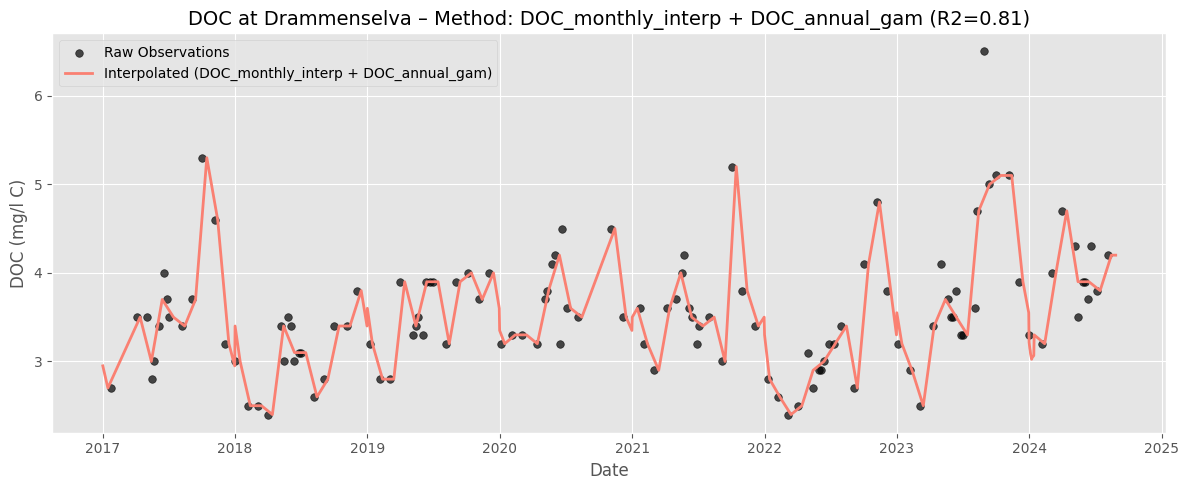

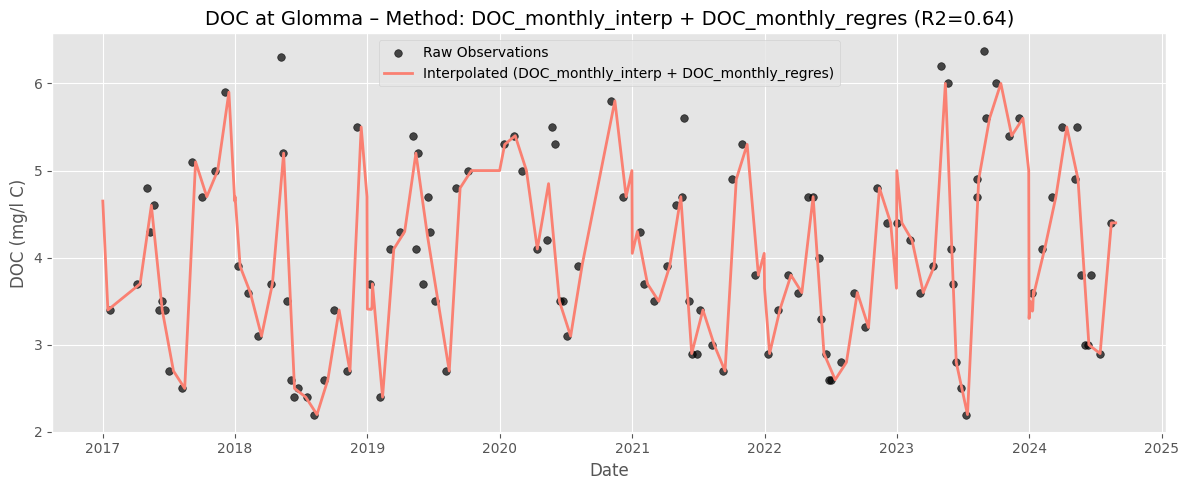

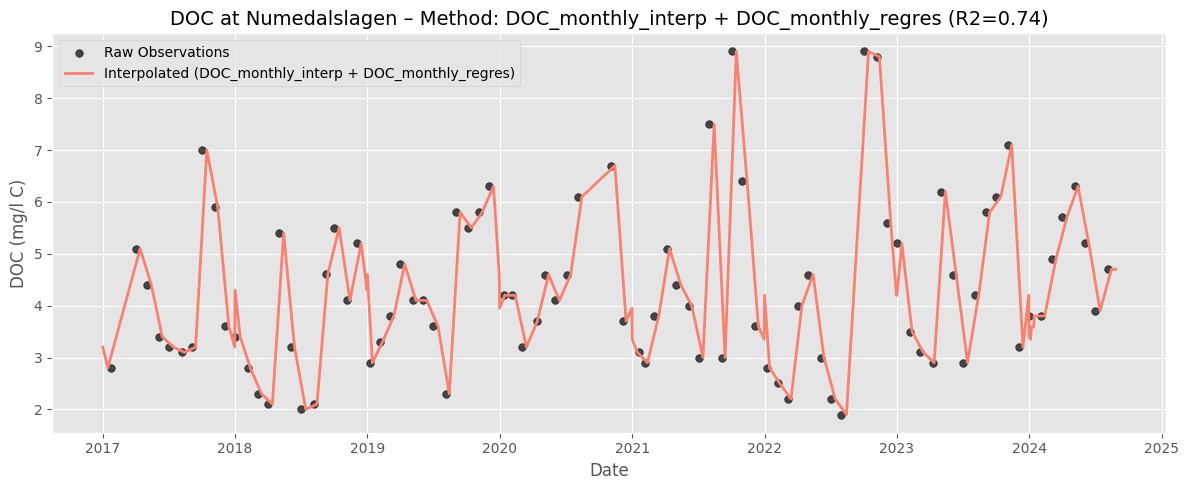

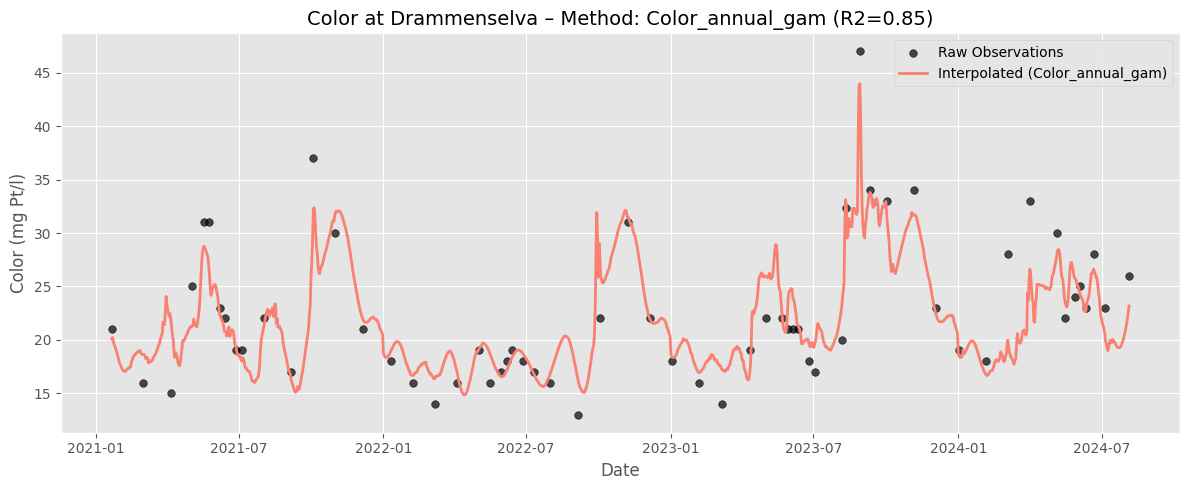

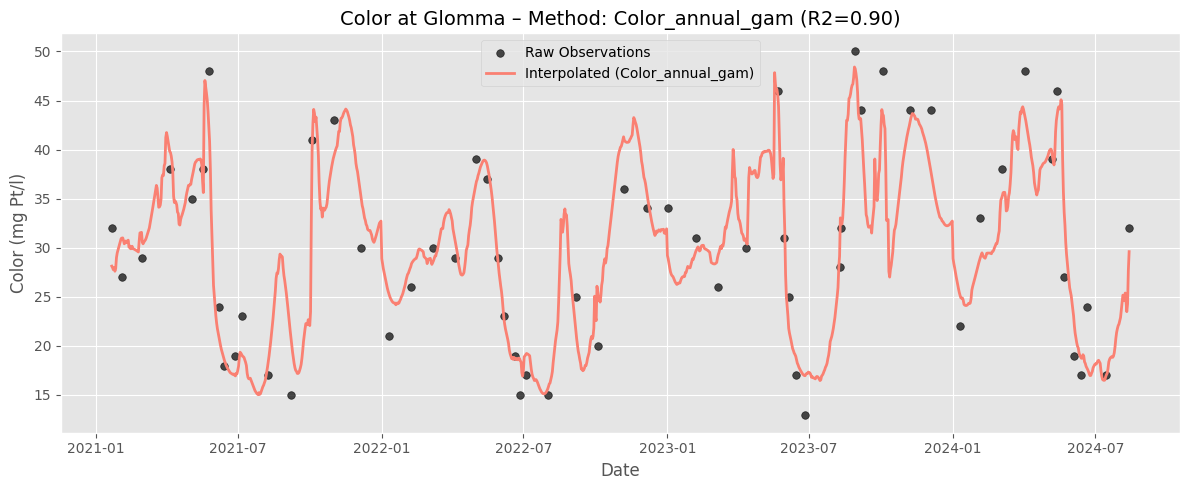

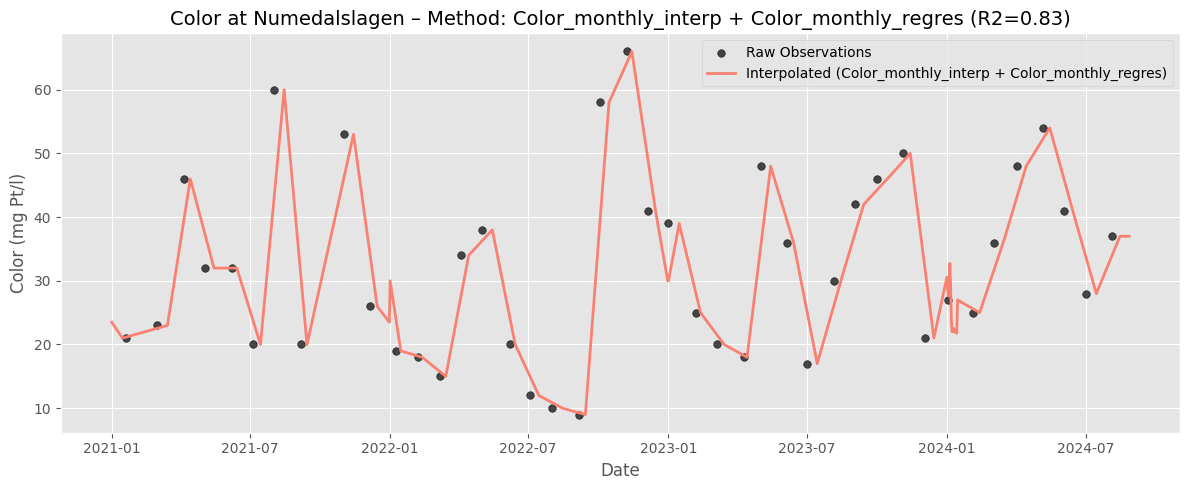

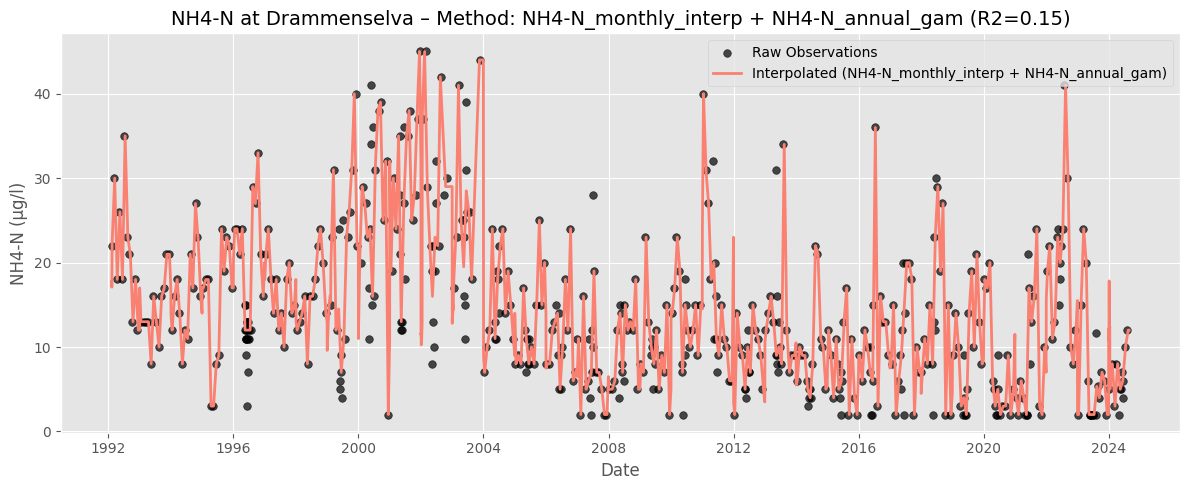

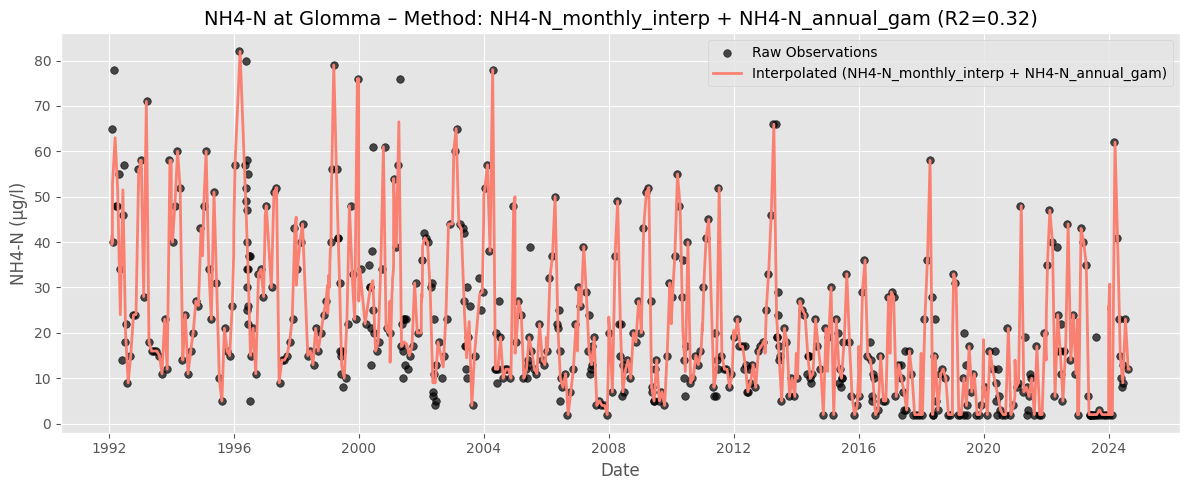

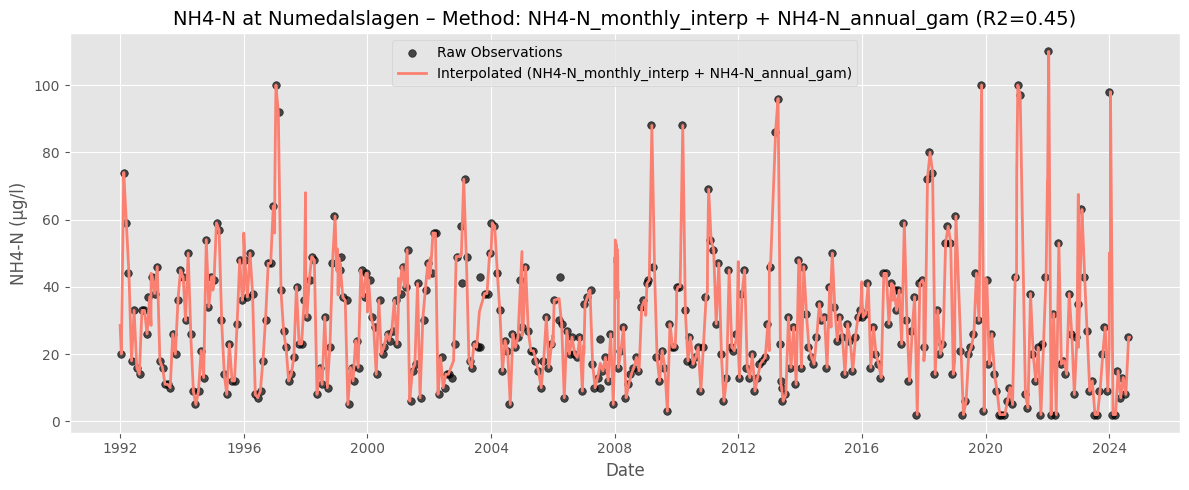

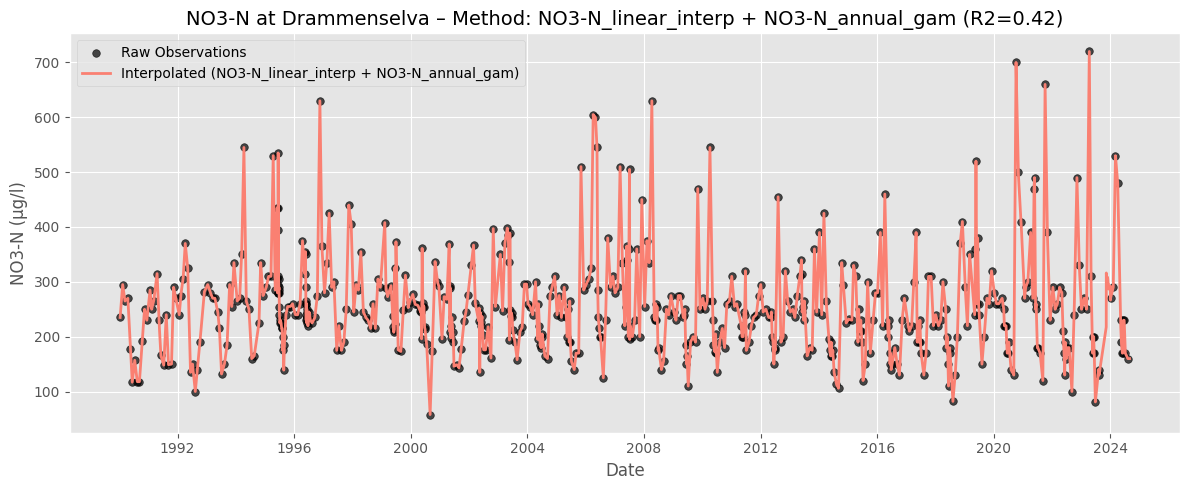

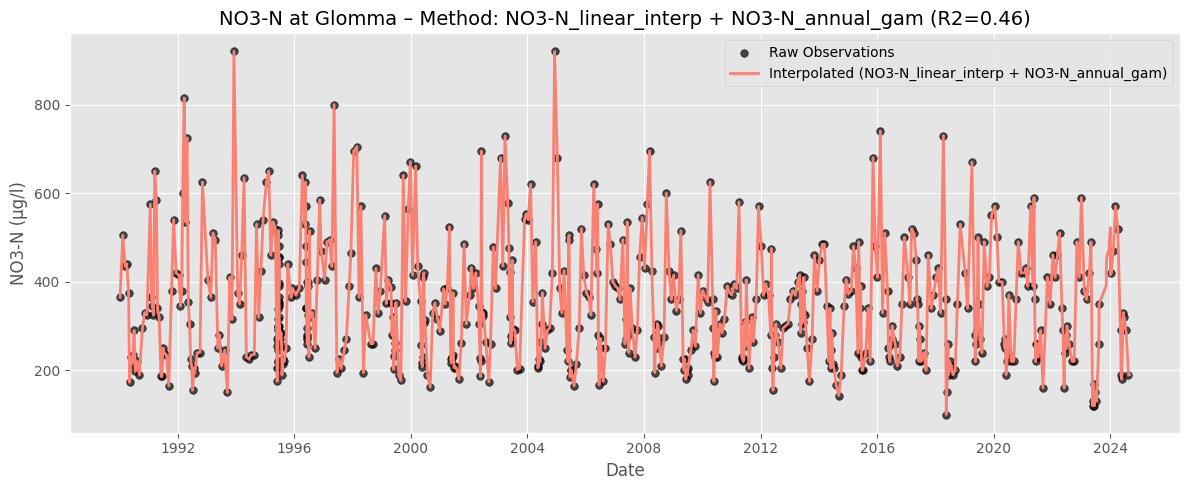

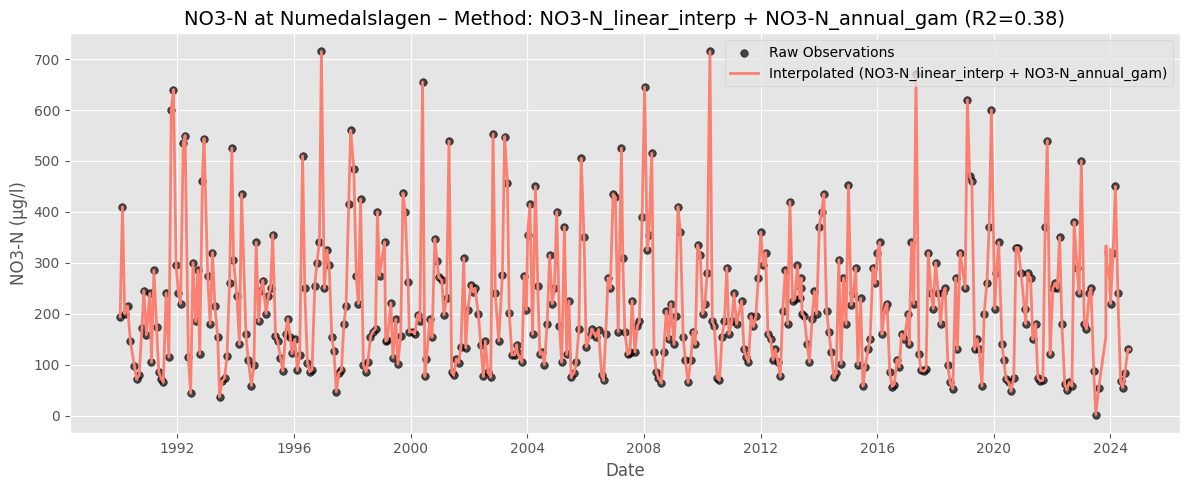

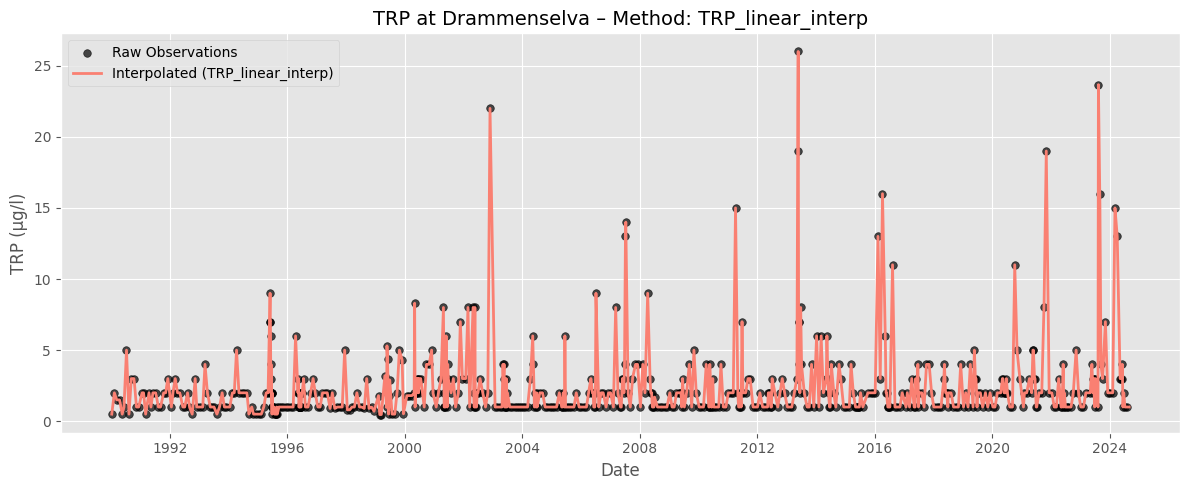

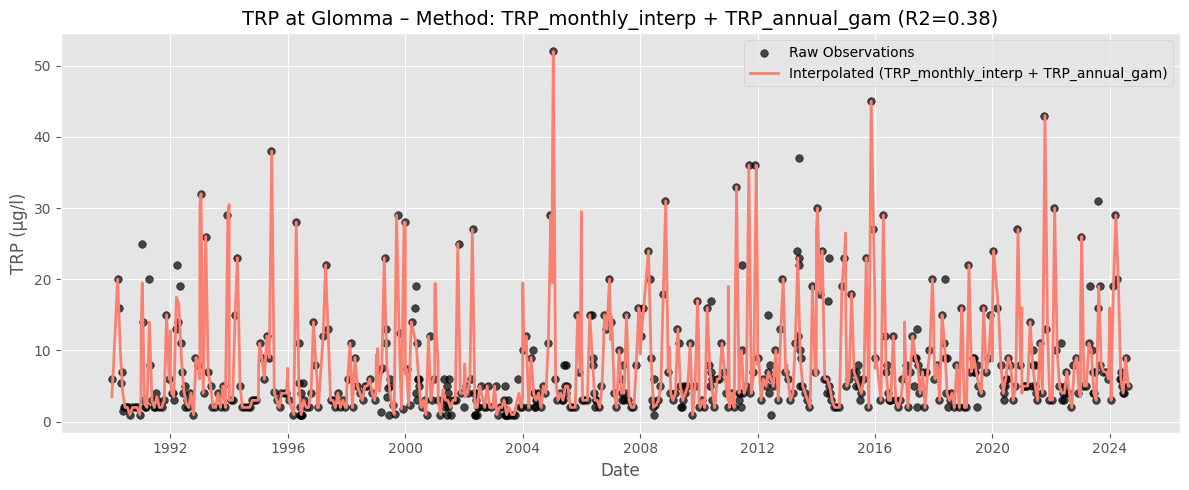

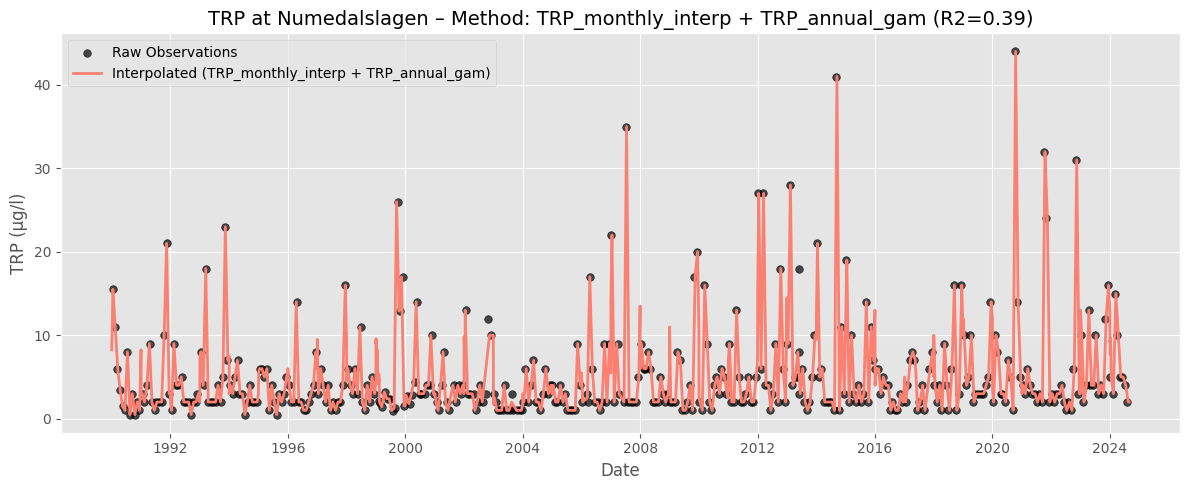

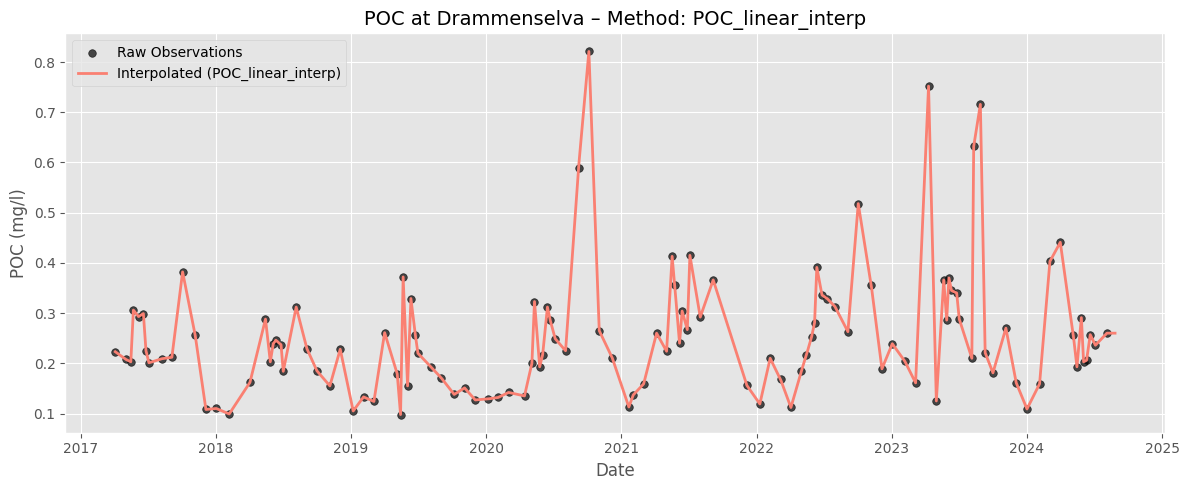

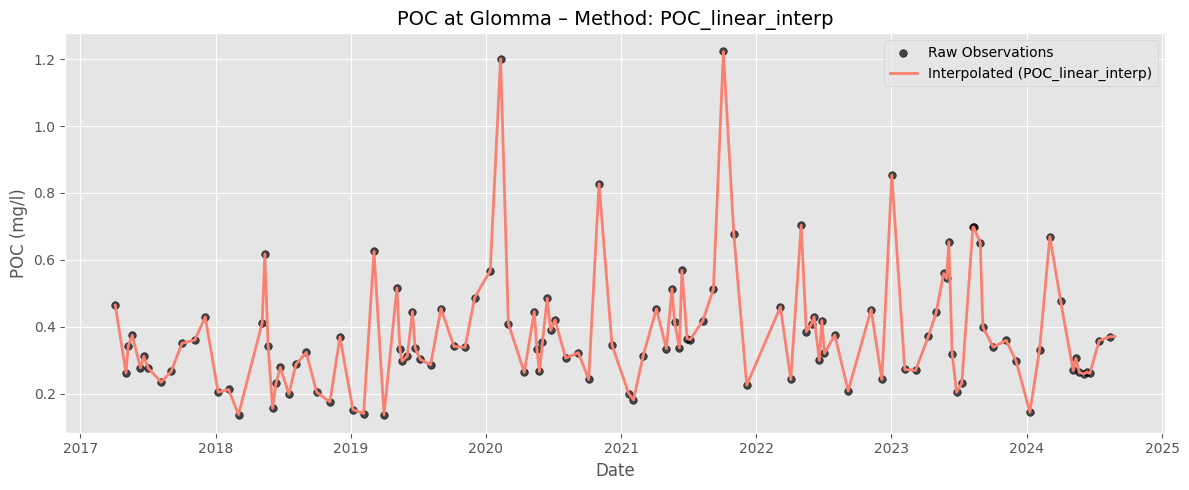

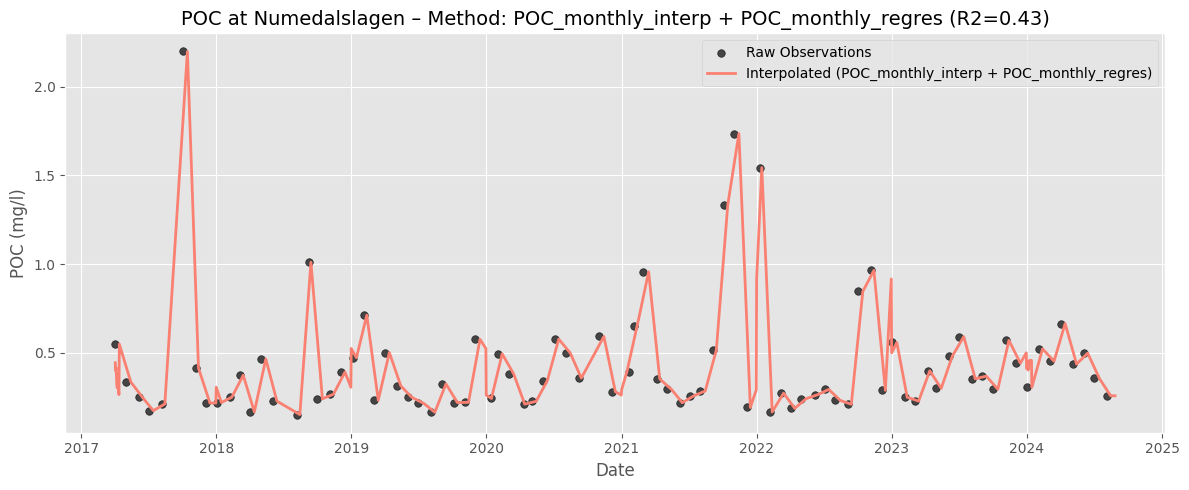

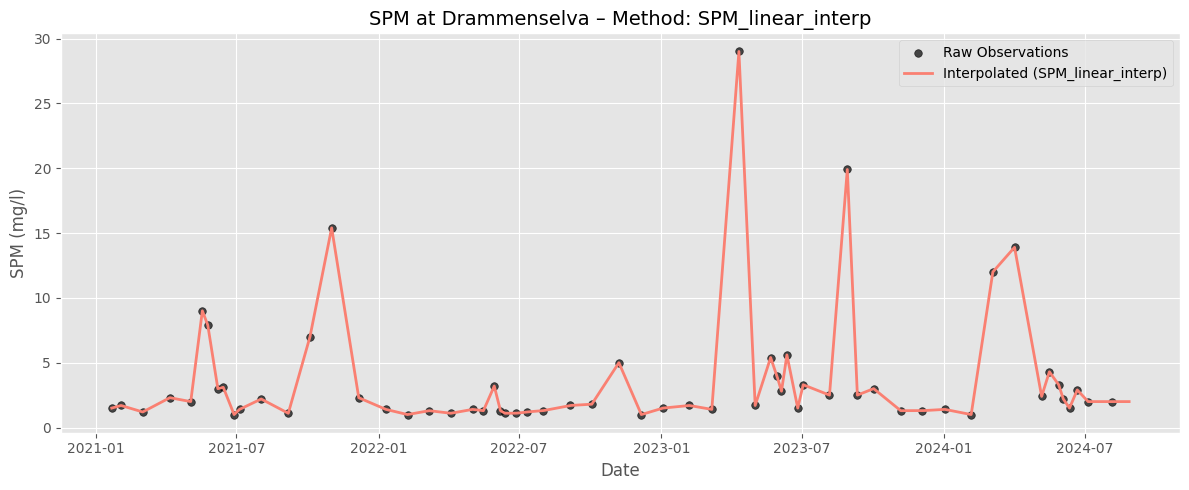

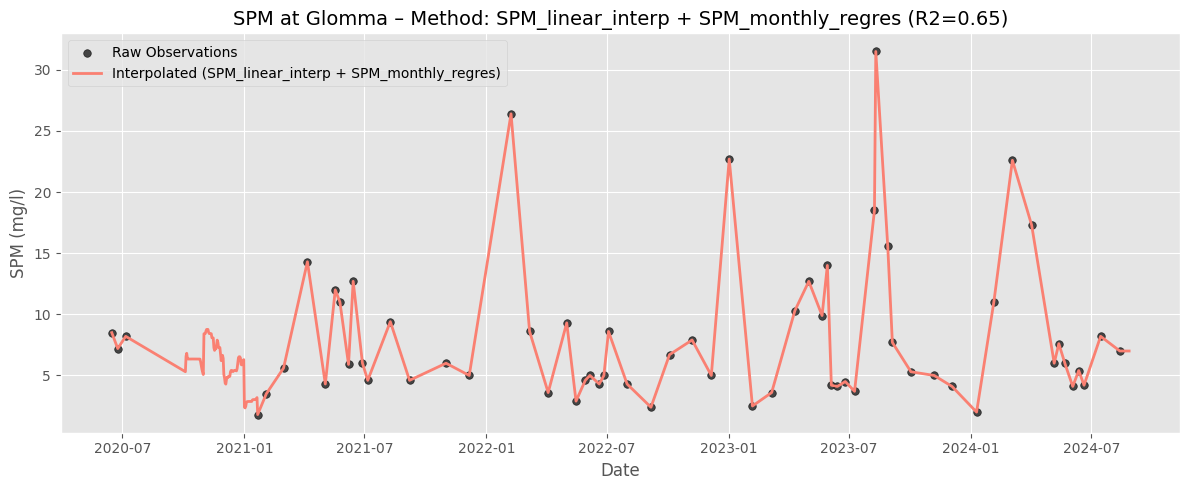

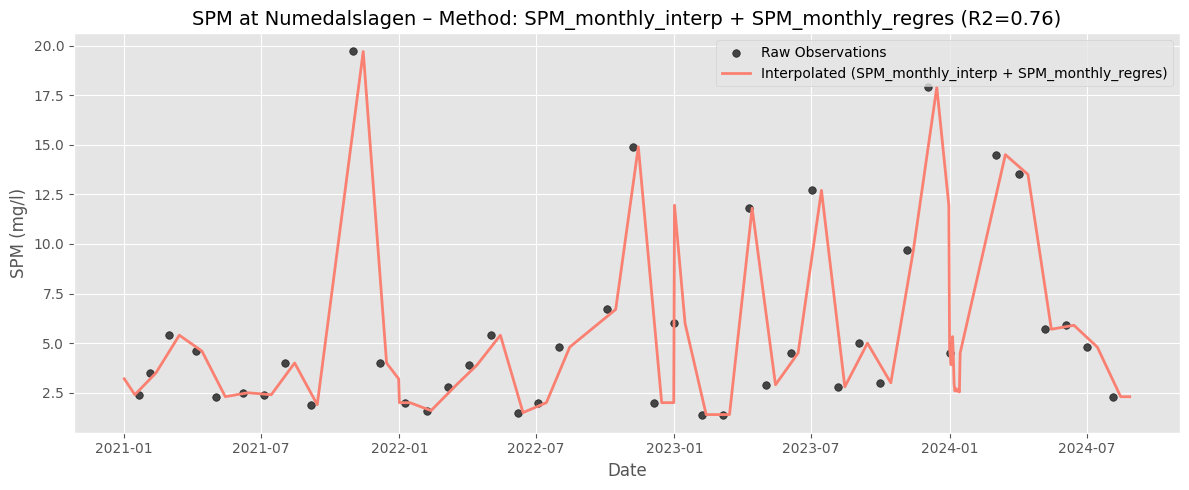

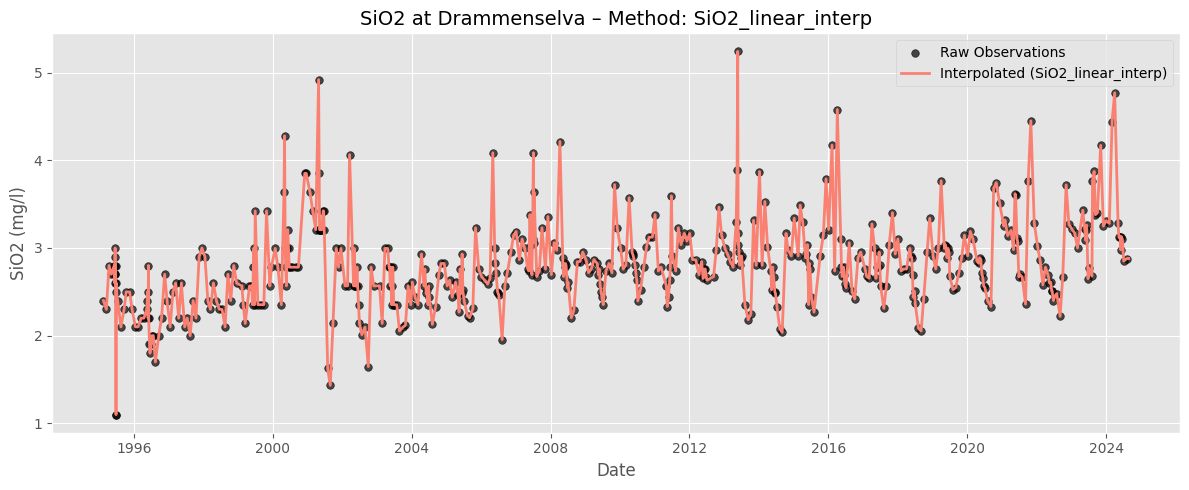

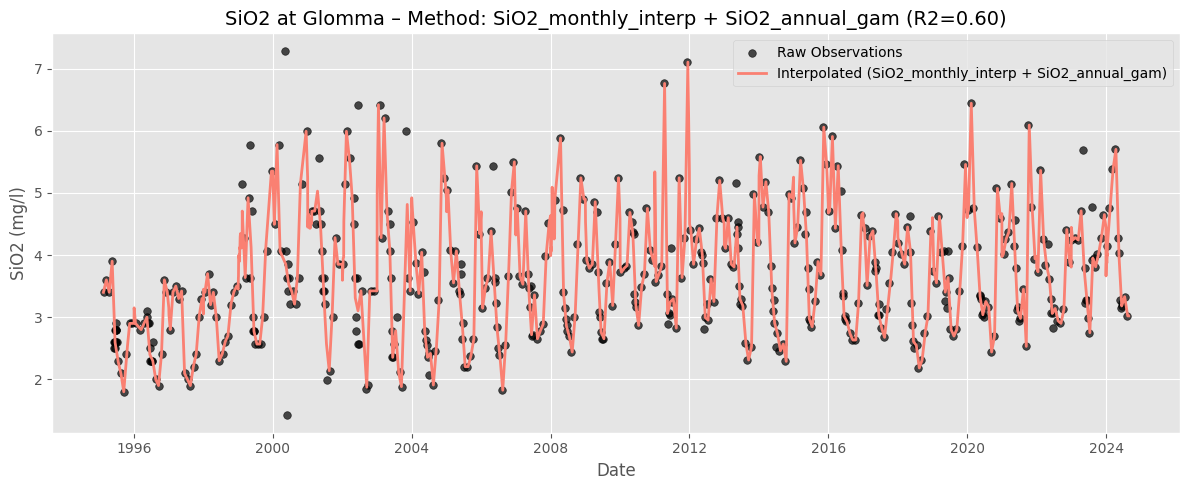

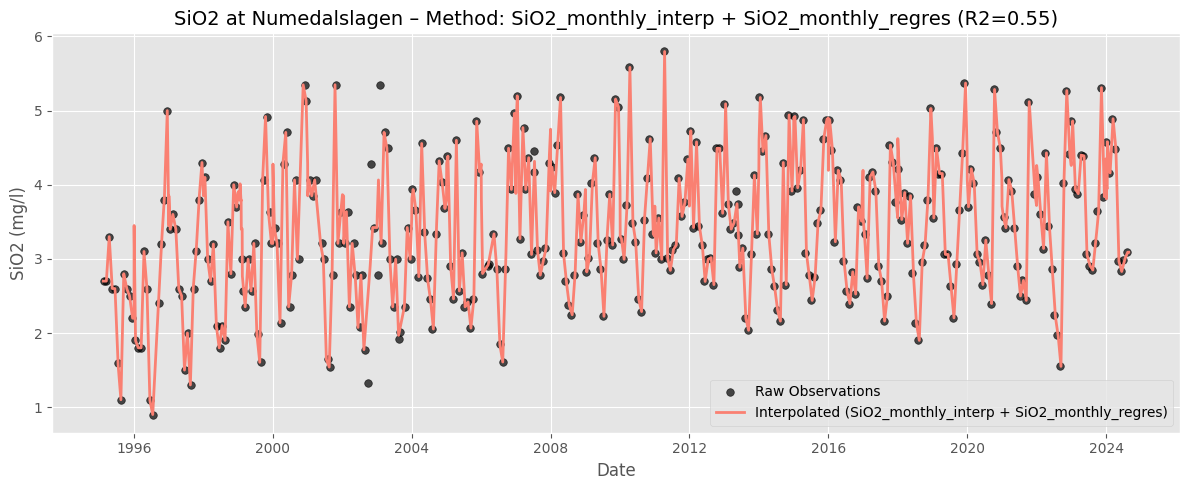

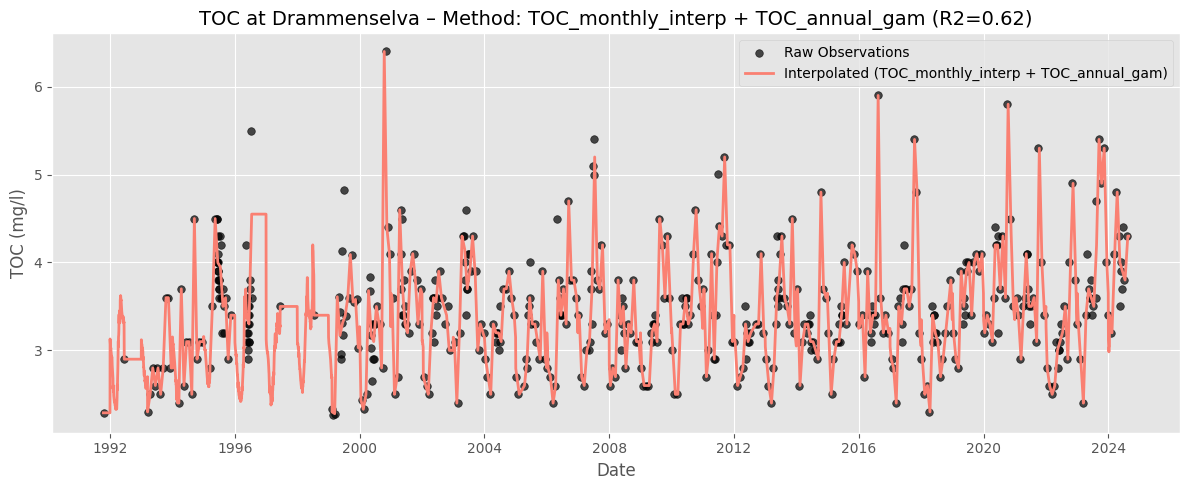

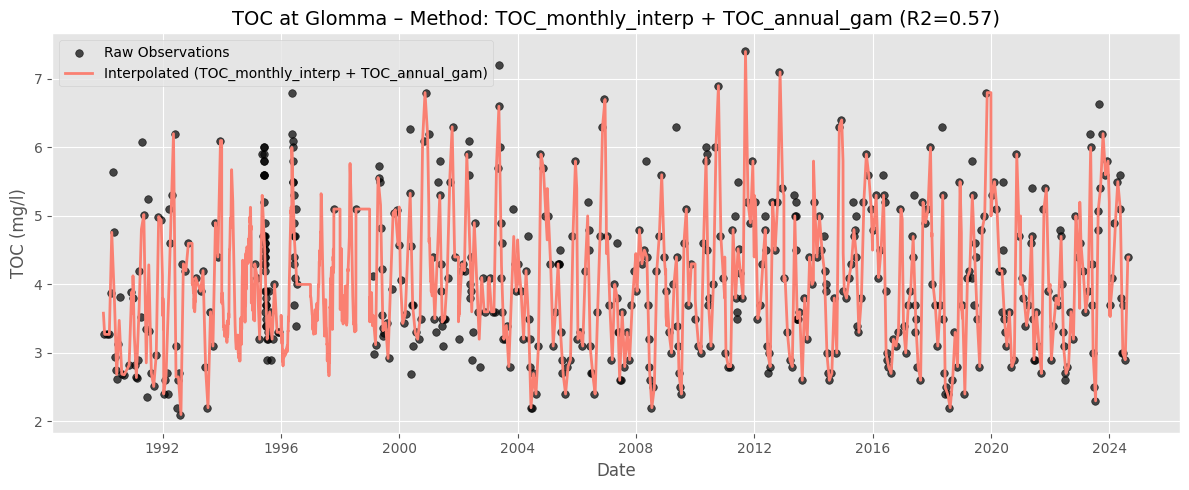

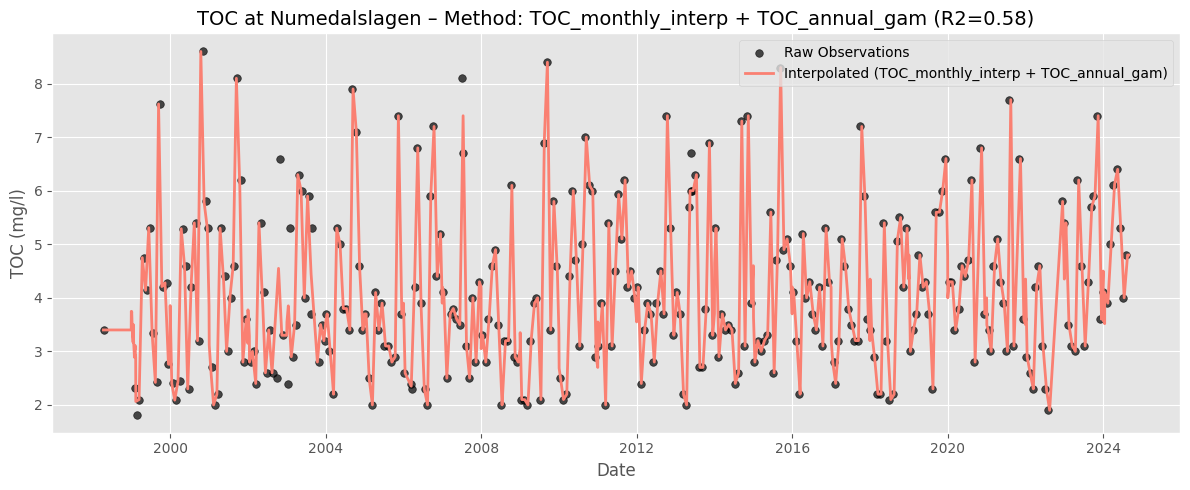

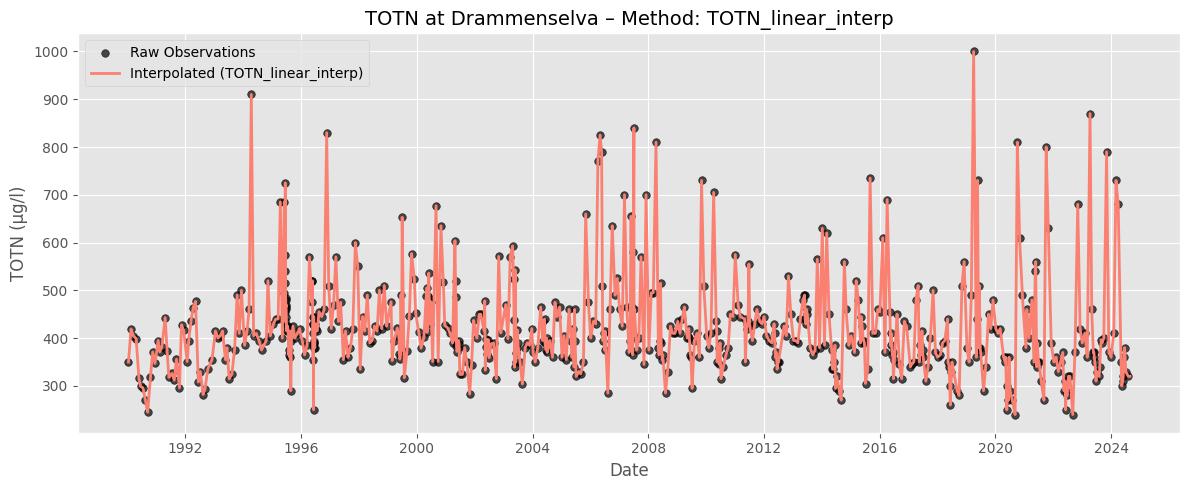

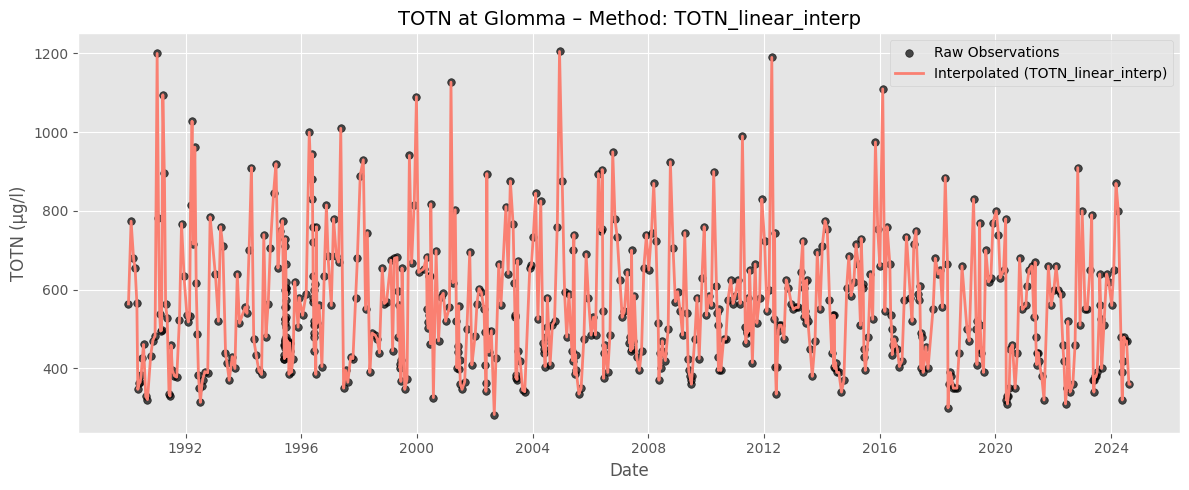

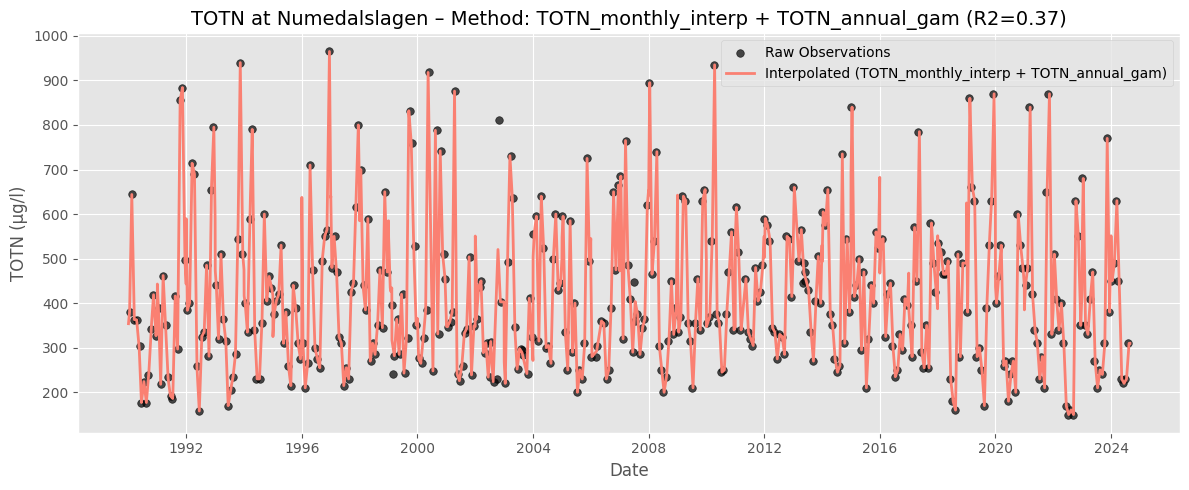

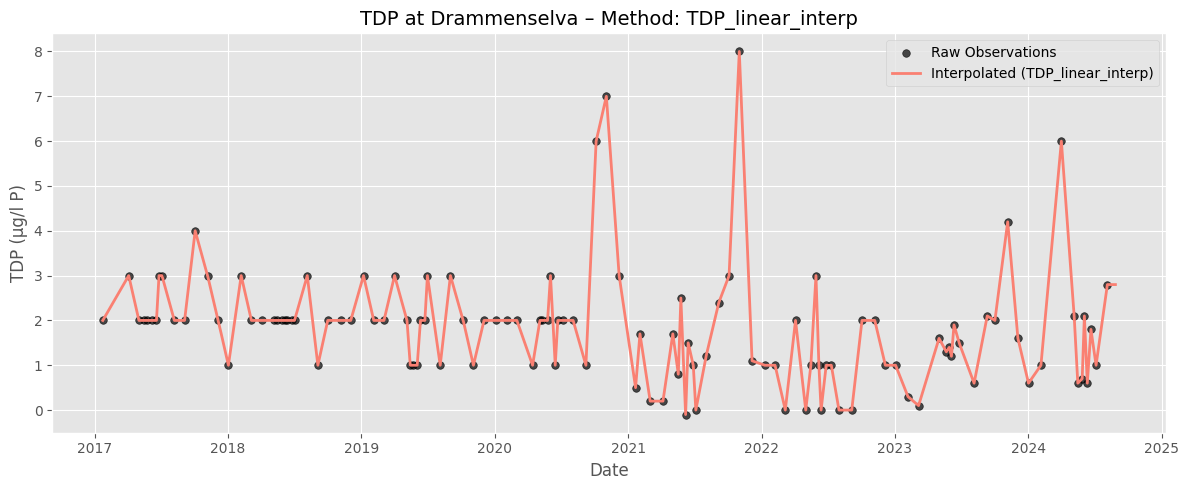

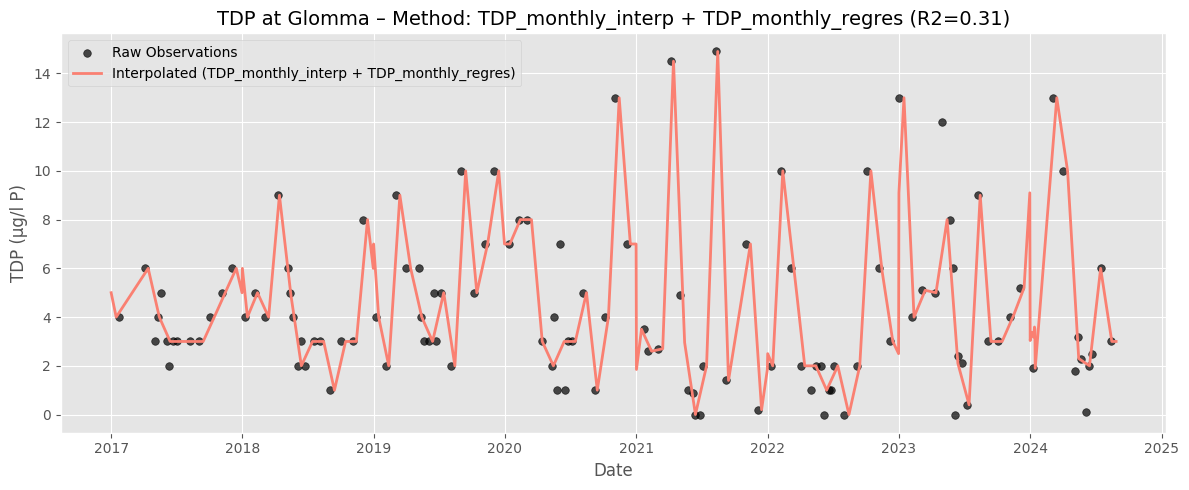

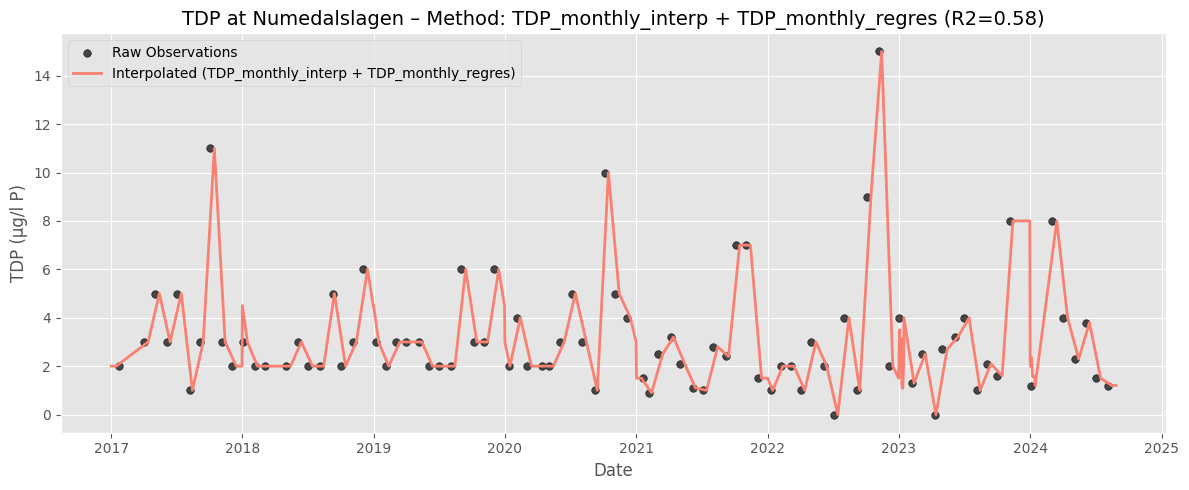

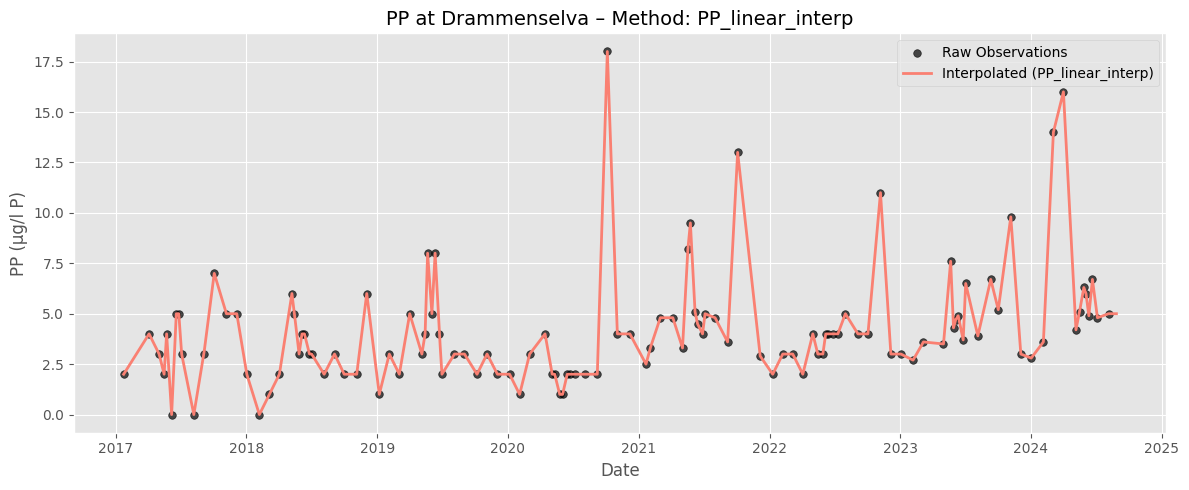

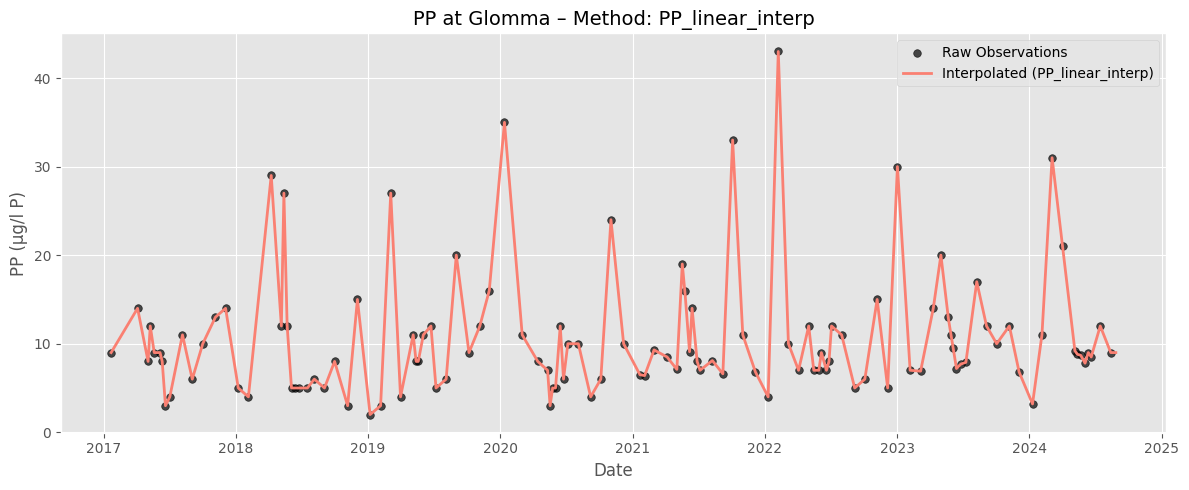

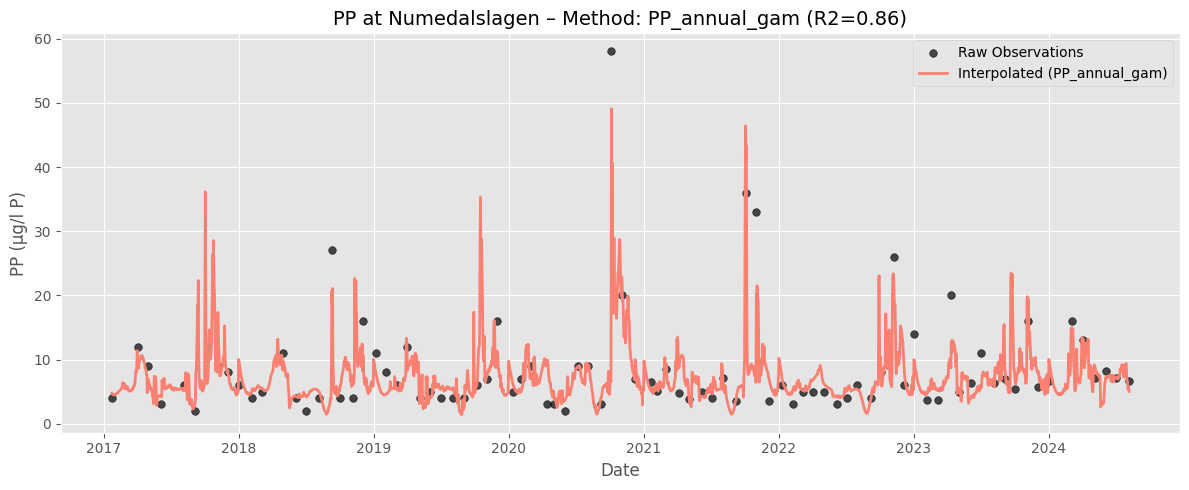

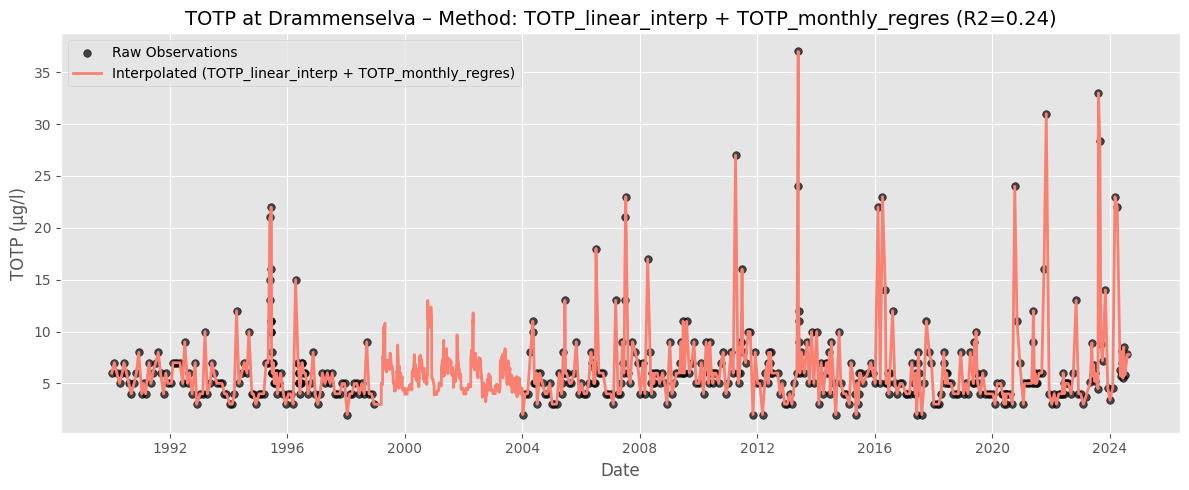

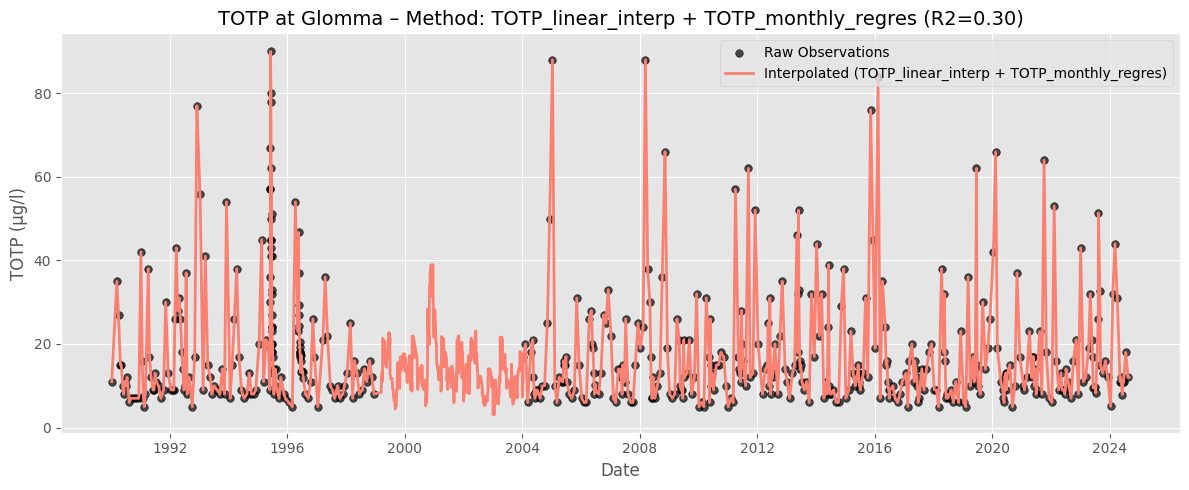

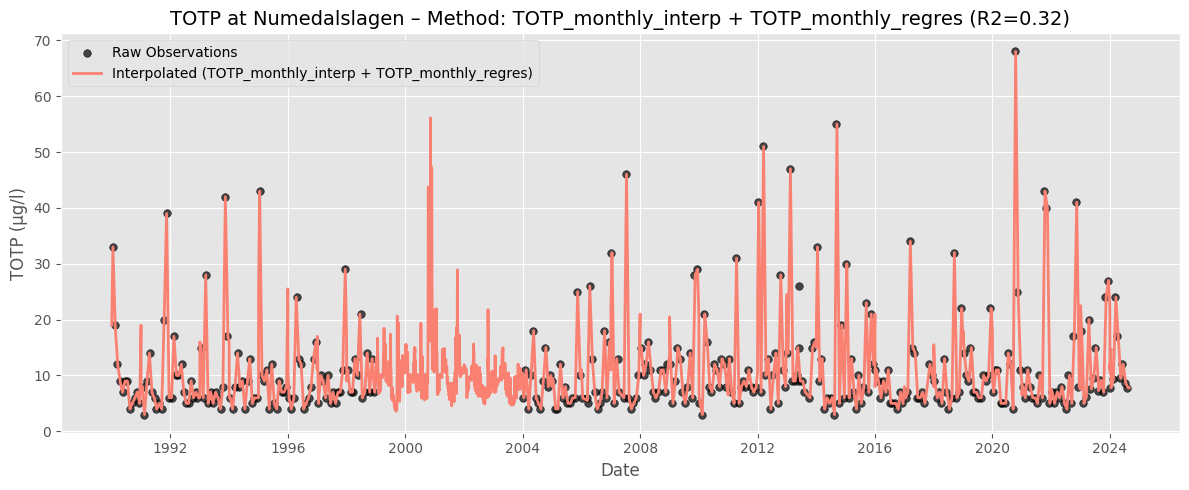

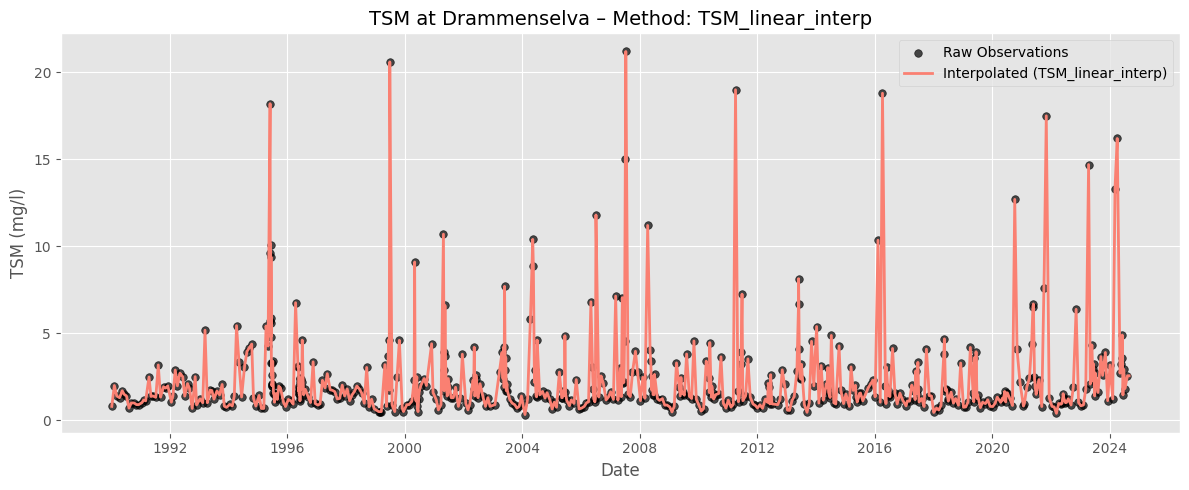

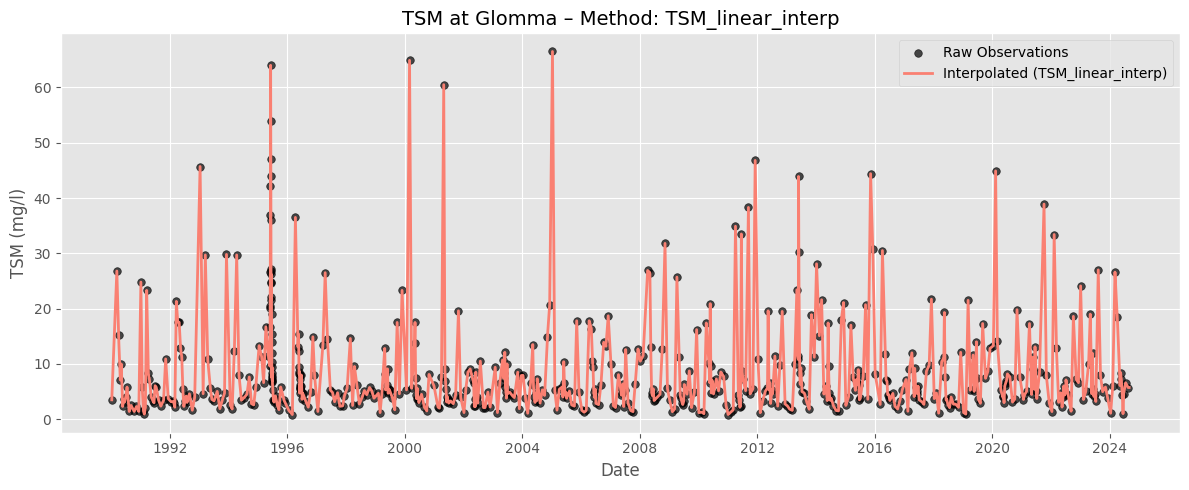

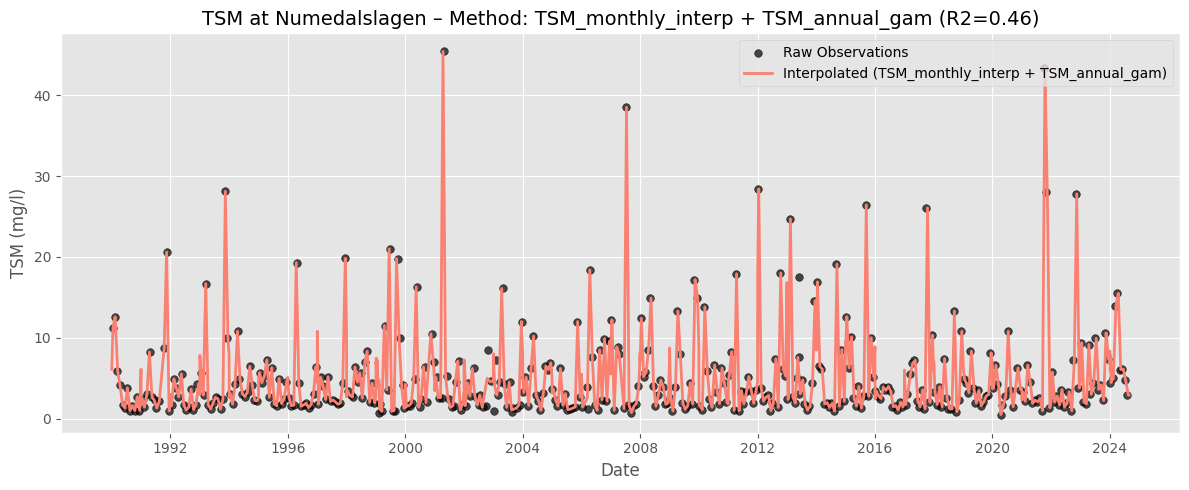

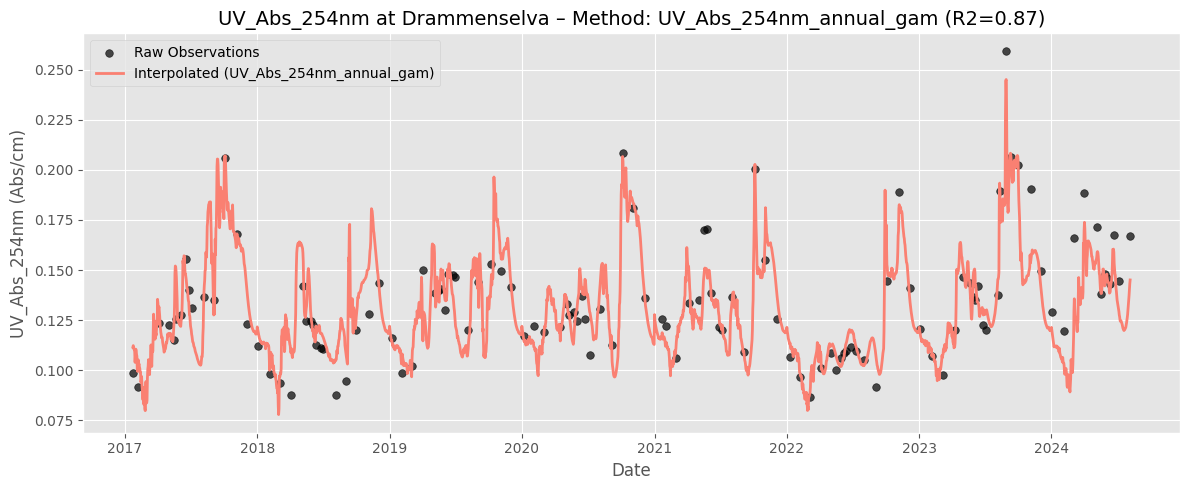

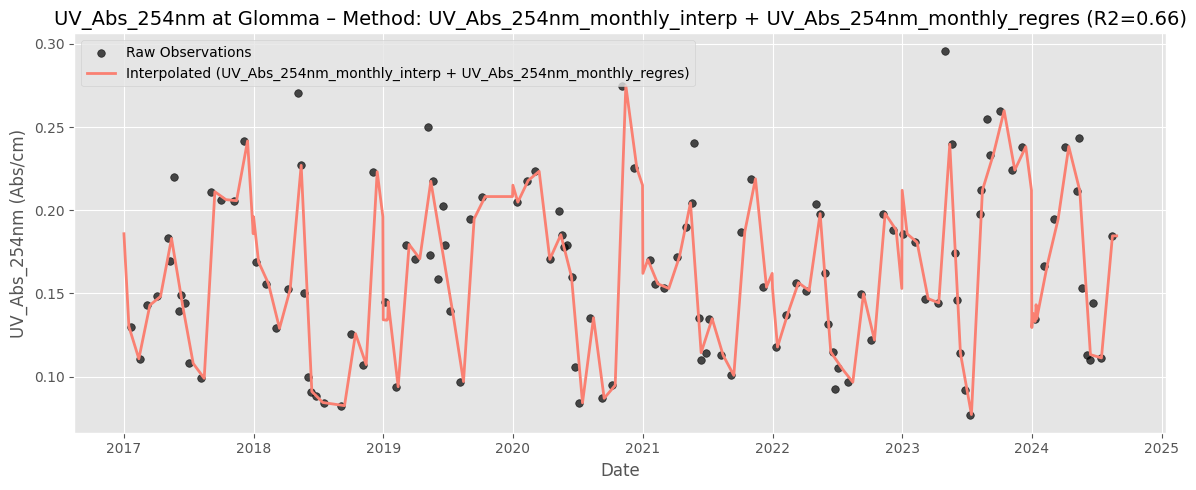

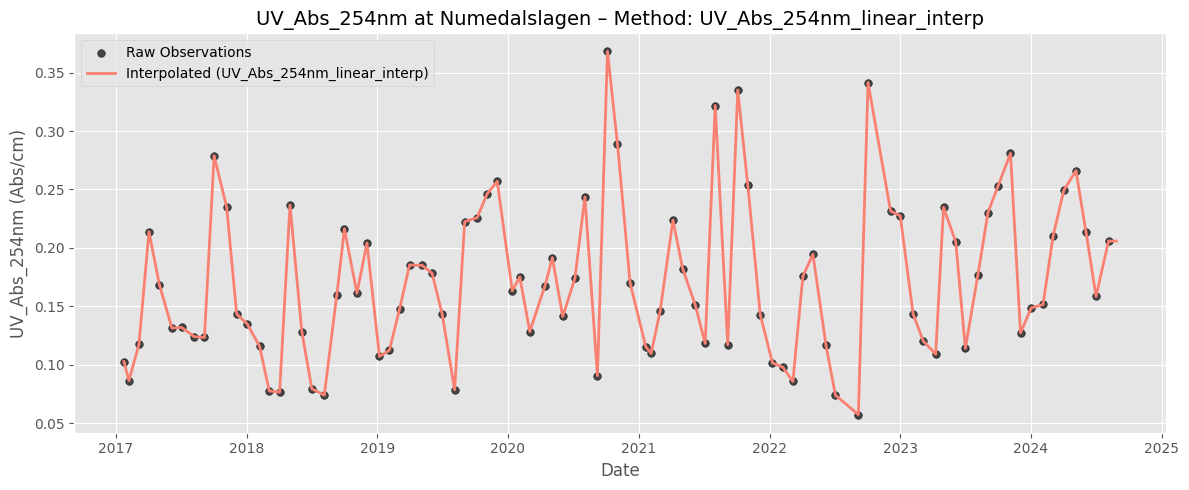

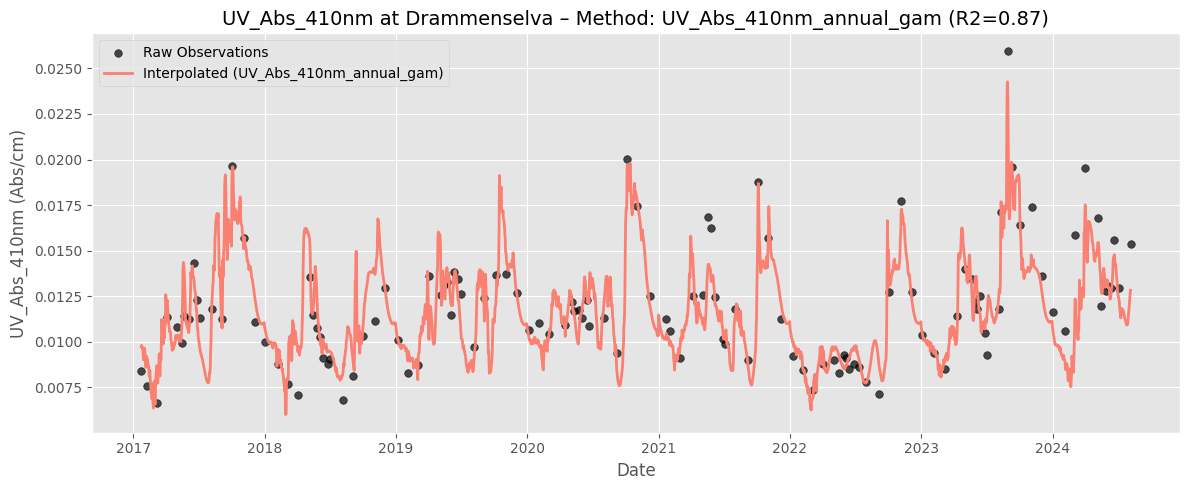

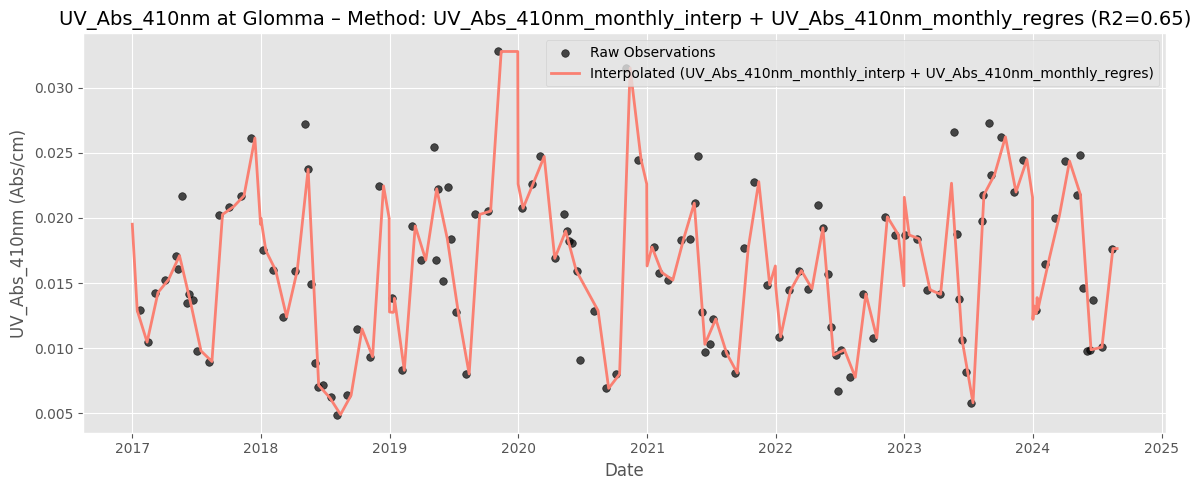

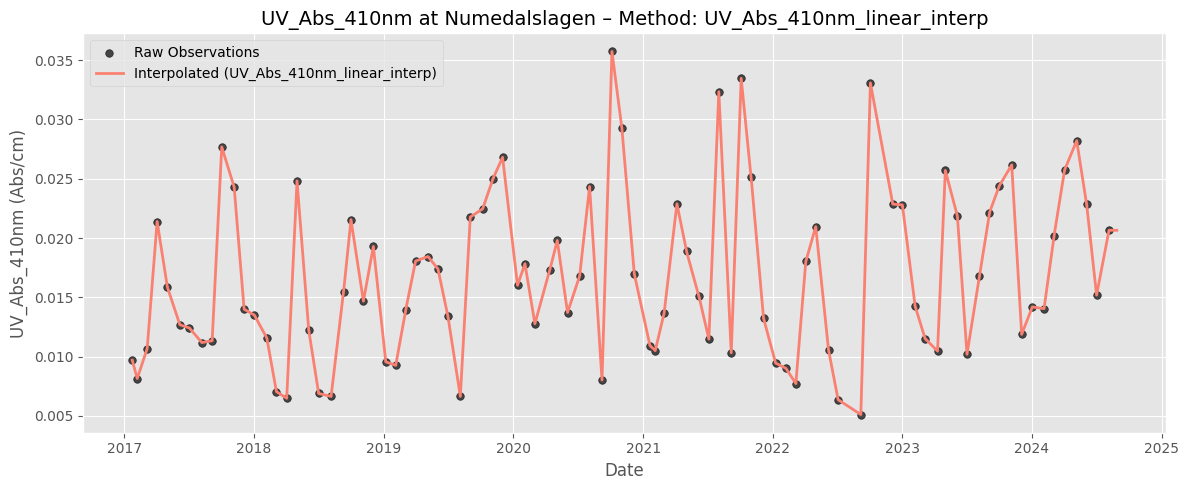

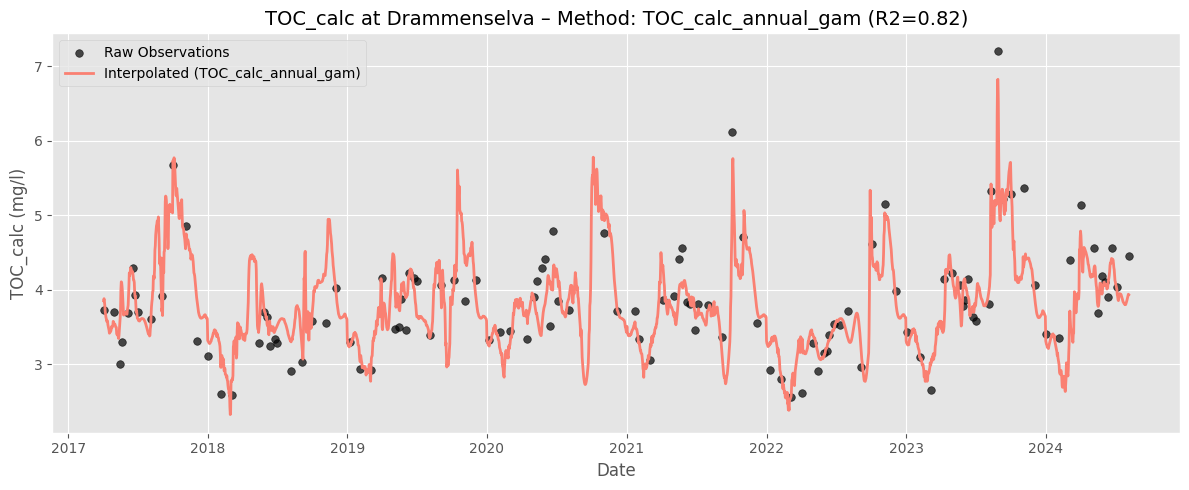

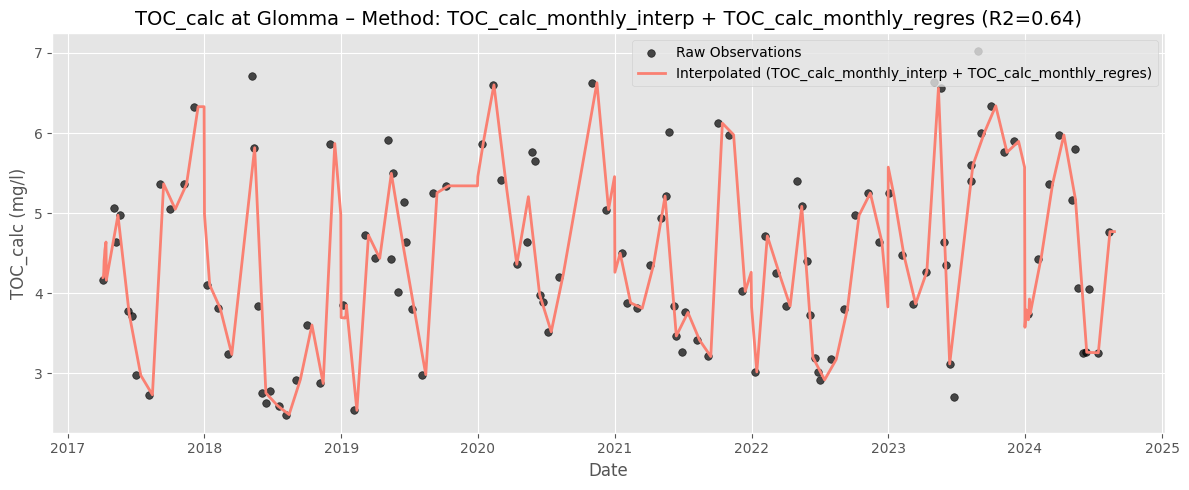

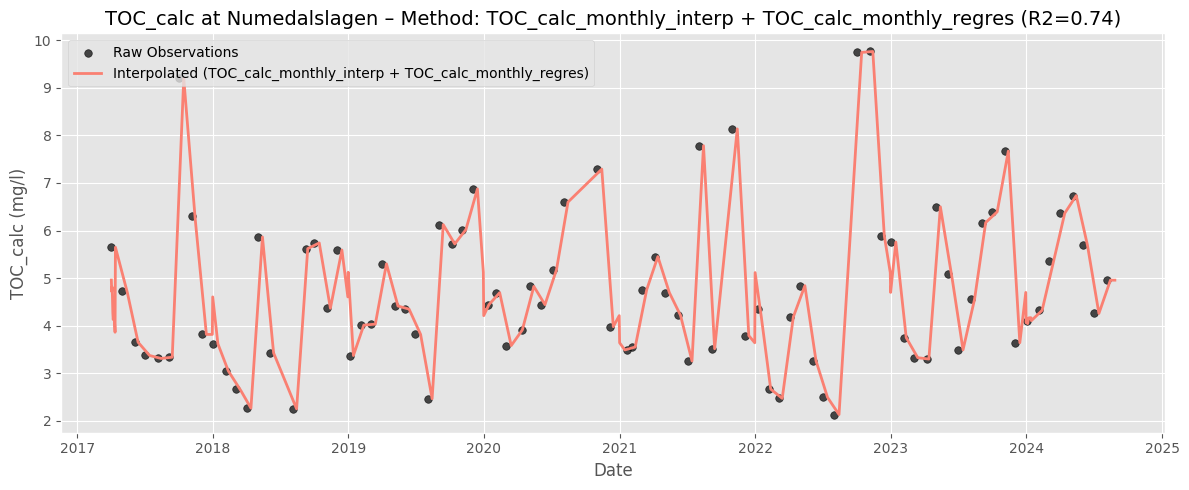

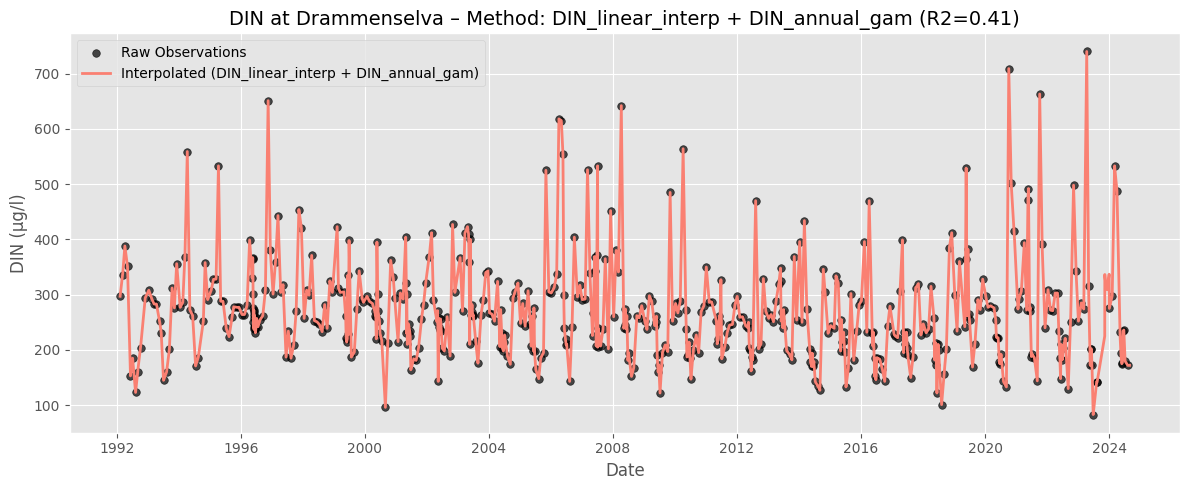

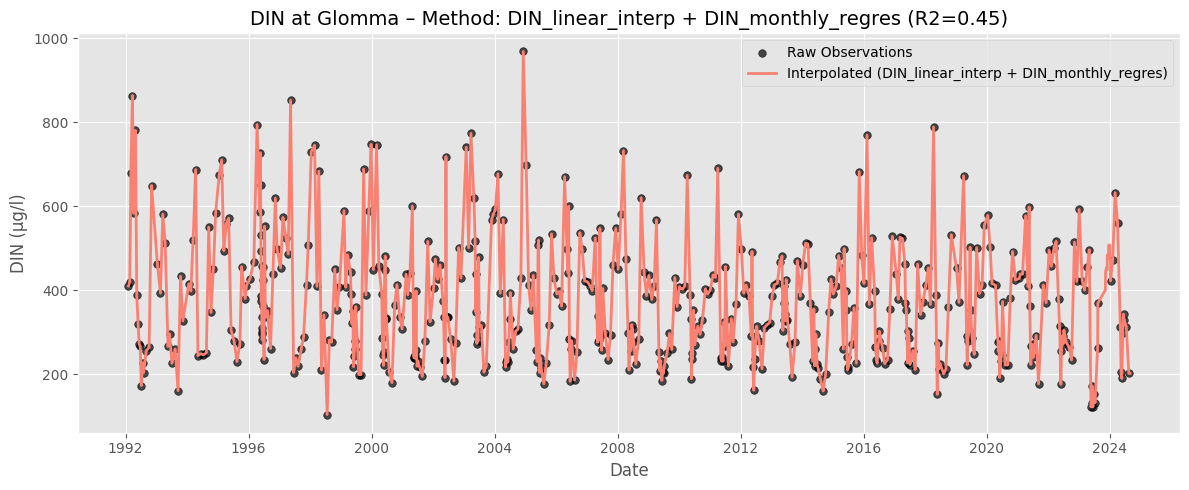

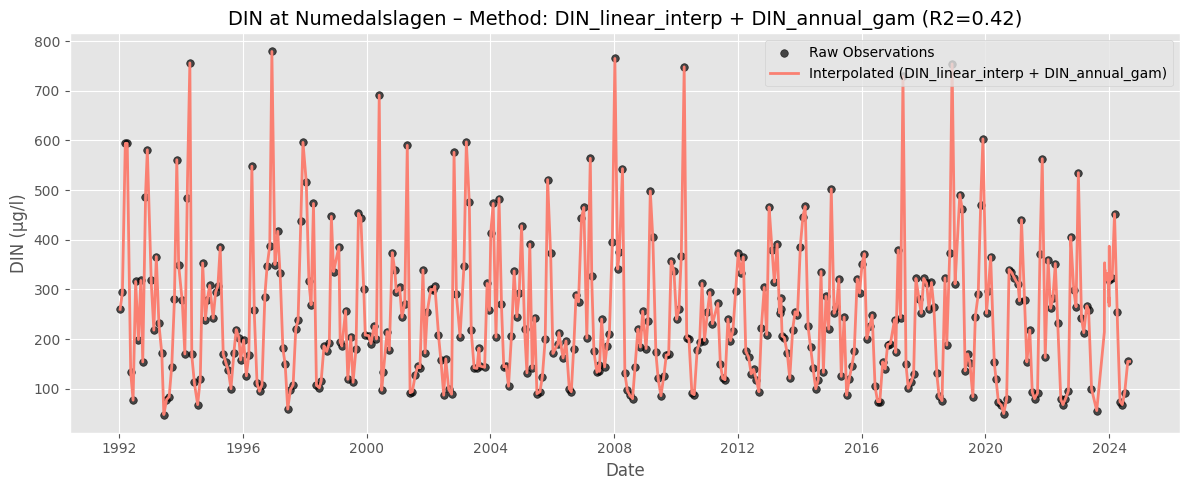

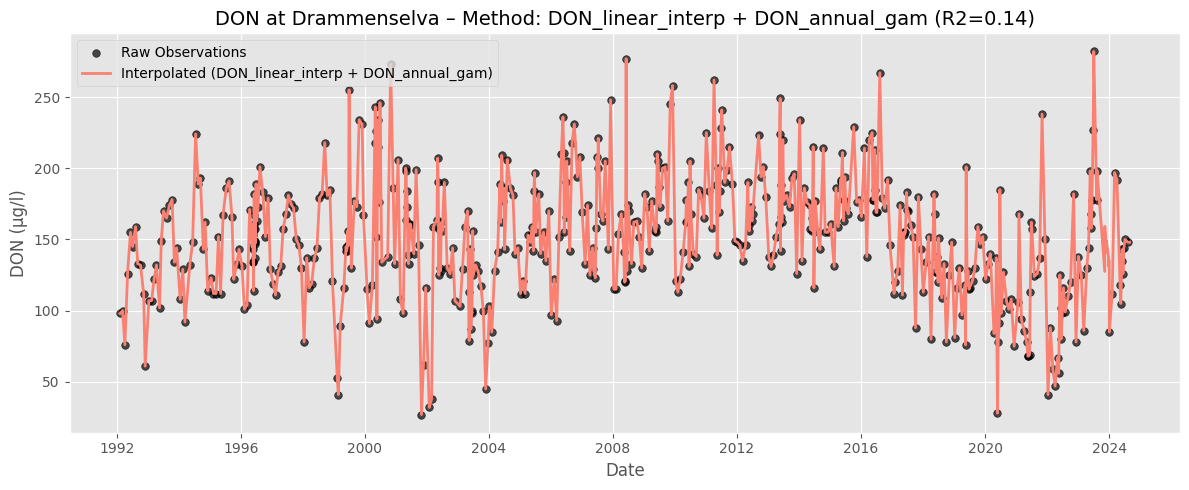

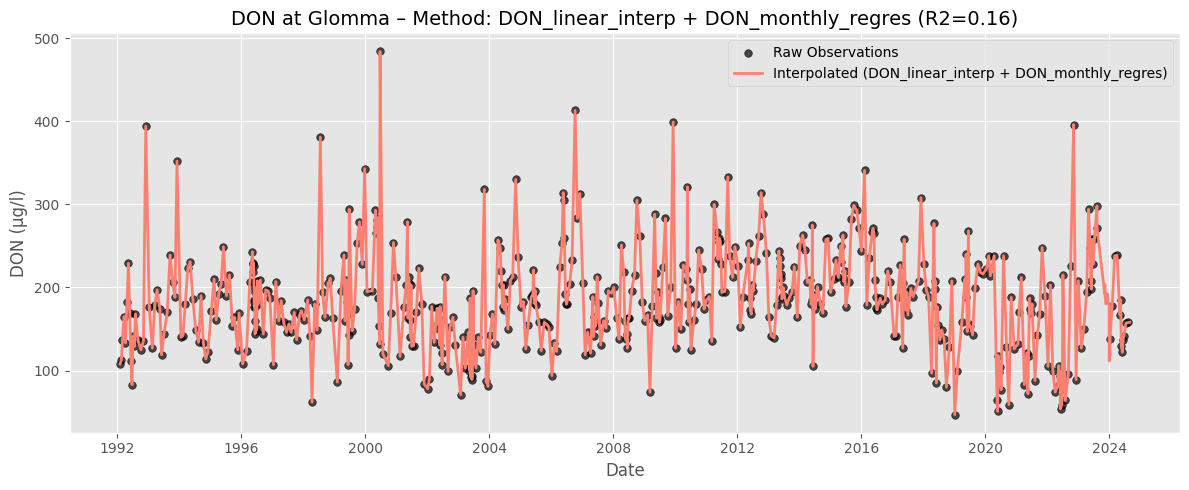

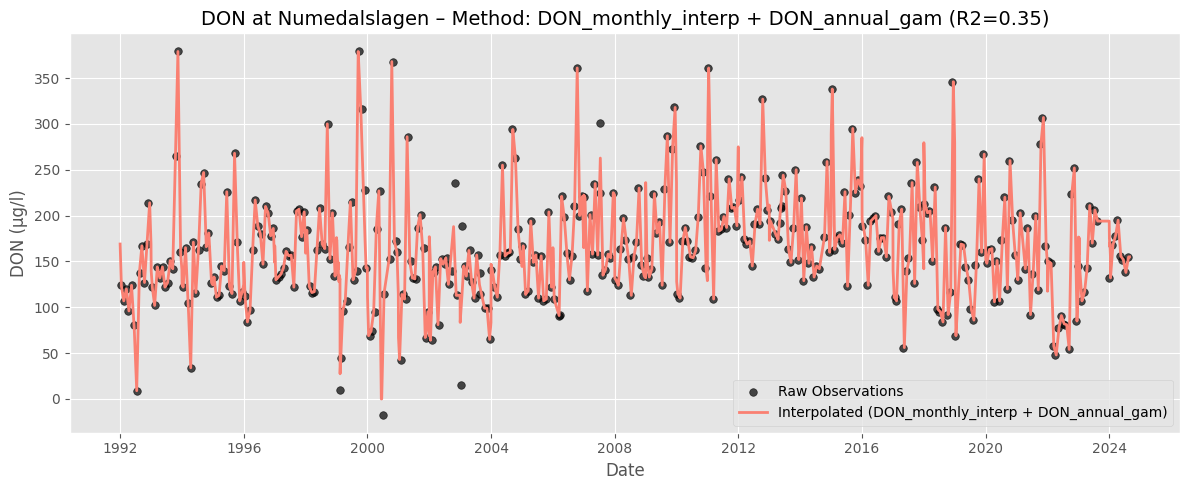

In [14]:
for var in chem_variables:
    for station in df_daily_all[station_col].unique():
        entry = selected_methods.get(var, {}).get(station, None)
        station_mask = df_daily_all[station_col] == station
        df_station = df_daily_all[station_mask].copy()

        if entry is None:
            continue

        if isinstance(entry, list):
            base_col = entry[0]
            fill_col = entry[1] if len(entry) > 1 else None
            merged = df_station[base_col].copy()
            if fill_col:
                merged = merged.fillna(df_station[fill_col])

            # Extract suffix and R2
            fallback_suffix = fill_col.replace(f"{var}_", "") if fill_col else None
            r2_val = method_scores.get(var, {}).get(station, {}).get(fallback_suffix, {}).get("R2", None)
            plot_qc_interpolation(df_station.assign(merged=merged), var=var, station=station, method_colname='merged', method_used=f"{base_col} + {fill_col}" if fill_col else base_col,  pars_metadata_df=pars_metadata_df, r2_value=r2_val)
            plot_path = os.path.join(plots_output_dir_b, f"{station}_{var}_selected_method.png")
            plt.savefig(plot_path)
            plt.close()

        else:
            pred_col = entry
            suffix = pred_col.replace(f"{var}_", "")
            r2_val = method_scores.get(var, {}).get(station, {}).get(suffix, {}).get("R2", None)
            plot_qc_interpolation(df_station, var=var, station=station, method_colname=pred_col, method_used=pred_col, pars_metadata_df=pars_metadata_df, r2_value=r2_val)
            plot_path = os.path.join(plots_output_dir_b, f"{station}_{var}_selected_method.png")
            plt.savefig(plot_path)
            plt.close()

In [15]:
# Filter to only _final columns for chemistry (exclude discharge and raw)
final_cols = [col for col in df_daily_all.columns if col.endswith('_final') and col != 'Q_final']

# Build final DataFrame
df_export = df_daily_all[[date_col, station_col] + final_cols].copy()

# Rename columns: strip "_final" suffix
df_export.rename(columns={col: col.replace('_final', '') for col in final_cols}, inplace=True)

# Sort
df_export = df_export.sort_values(by=[station_col, date_col])

# Split by station 
df_groups = dict(tuple(df_export.groupby(station_col)))

### 7. Create datasets and assign metadata and global attributes

In [16]:
datasets = []

for station_name, df in df_groups.items():
    df = df.copy()
    df["date"] = pd.to_datetime(df[date_col])
    df = df.set_index("date")

    # Convert to xarray.Dataset
    ds = xr.Dataset.from_dataframe(df.drop(columns=[station_col]))

    # Add coords
    ds = ds.assign_coords(sample_date=("date", df.index))
    ds["date"].attrs.update({
        "standard_name": "time",
        "long_name": "Time of measurement",
        "axis": "T"
    })

    if station_name in river_coords:
        lat = river_coords[station_name]["lat"]
        lon = river_coords[station_name]["lon"]

        ds = ds.assign_coords(
            latitude=xr.DataArray(lat, dims=(), attrs={
                "standard_name": "latitude",
                "long_name": "Latitude",
                "units": "degree_north"
            }),
            longitude=xr.DataArray(lon, dims=(), attrs={
                "standard_name": "longitude",
                "long_name": "Longitude",
                "units": "degree_east"
            })
        )
        ds = ds.set_coords(["latitude", "longitude"])
    else:
        print(f"No coordinates found for {station_name}")

    # Add scalar station metadata
    ds["river_name"] = xr.DataArray(station_name, dims=(), attrs={"cf_role": "timeseries_id"})

    # Annotate variables with units, names, and comments
    for var in ds.data_vars:
        if var in pars_metadata_df["parameter_name"].values:
            match = pars_metadata_df[pars_metadata_df["parameter_name"] == var].iloc[0]
            ds[var].attrs["units"] = match["unit"]
            ds[var].attrs["long_name"] = standard_name_map.get(var, var)
        if var in var_comments:
            if isinstance(var_comments[var], dict) and station_name in var_comments[var]:
                ds[var].attrs["comment"] = var_comments[var][station_name]

    datasets.append((station_name, ds))

# Metadata example
station_name, ds = datasets[2]
print(f"Station: {station_name}")
print(ds["TOTN"].attrs)

Station: Numedalslagen
{'units': 'µg/l', 'long_name': 'Total Nitrogen', 'comment': 'The daily TOTN time series was estimated using monthly median interpolation; 84 missing values were filled using the fallback TOTN annual GAM time series.'}


In [17]:
int_encoding = {"dtype": "int32", "_FillValue": -9999}

for station_name, ds in datasets:
    # Get lat/lon
    lat = float(ds["latitude"].values.item())
    lon = float(ds["longitude"].values.item())

    # Generate UUID from river name
    unique_id = f"no.niva:{uuid.uuid5(processed_namespace_uuid, station_name)}"

    # Prepare metadata
    dataset_metadata = global_metadata_config.copy()
    dataset_metadata.update({
        "id": unique_id,
        "title": f"Daily water chemistry concentrations estimated for river {station_name}",
        "title_no": f"Estimerte daglige konsentrasjoner av vannkjemi for elv {station_name}",
        "summary": (
            f"Daily time series of water chemistry for river {station_name}, estimated by harmonizing observed "
            f"data and interpolating missing values. Multiple gap-filling techniques were applied: linear interpolation "
            f"with gap limits, generalized additive models (GAMs), monthly regression models (log–log discharge–chemistry), "
            f"and monthly median interpolation to daily resolution. This dataset was prepared to enable daily flux calculations"
            f"and support long-term seasonal trend analysis in Norwegian rivers. Interpolation methods ensure continuity"
            f"in time series for integration with discharge data and downstream water quality assessments."
        ),
        
        "summary_no": (
            f"Daglige tidsserier for vannkjemi ved elv {station_name}, beregnet ved å harmonisere observerte målinger og "
            f"interpolere manglende verdier. Flere metoder for å fylle datagap er brukt: lineær interpolasjon med "
            f"maksimal gaplengde, generaliserte additive modeller (GAM), månedlige regresjonsmodeller (log–log avrenning–kjemi), "
            f"og interpolasjon fra månedlige medianer til daglig oppløsning. Dette datasettet er utarbeidet for å muliggjøre daglige"
            f"fluksberegninger og støtte langtidsanalyse av sesongvariasjoner i norske elver. Interpolasjonsmetodene sikrer kontinuitet"
            f"i tidsseriene for integrasjon med vannføringsdata og videre vurderinger av vannkvalitet."
        ),
        "date_created": datetime.now(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
        "time_coverage_start": np.datetime_as_string(ds.sample_date.min().values, unit="s", timezone="UTC"),
        "time_coverage_end": np.datetime_as_string(ds.sample_date.max().values, unit="s", timezone="UTC"),
        "geospatial_lat_min": lat,
        "geospatial_lat_max": lat,
        "geospatial_lon_min": lon,
        "geospatial_lon_max": lon,
    })

    # Assign metadata
    ds.attrs = {k: str(v) for k, v in dataset_metadata.items()}

    # Prepare encoding
    encoding = {
        "sample_date": {
            "dtype": "int32",
            "_FillValue": None,
            "units": "seconds since 1970-01-01 00:00:00",
        },
        "latitude": {"_FillValue": None},
        "longitude": {"_FillValue": None},
    }

    output_dir = Path(output_dir)
    output_path = output_dir / f"daily_water_chemistry_modeled_{station_name.lower().replace(' ', '_')}.nc"

    ds.to_netcdf(output_path, encoding=encoding, format="NETCDF4")
    print(f"Saved NetCDF: {output_path}")

Saved NetCDF: ..\..\data\river\water_chemistry\daily_estimations\daily_water_chemistry_modeled_drammenselva.nc
Saved NetCDF: ..\..\data\river\water_chemistry\daily_estimations\daily_water_chemistry_modeled_glomma.nc
Saved NetCDF: ..\..\data\river\water_chemistry\daily_estimations\daily_water_chemistry_modeled_numedalslagen.nc
